In [1]:
!pip install -q pytorch-lightning==2.4.0

In [2]:
!pip install -q transformers==4.46.2 datasets==2.21.0 roboflow==1.1.49

In [3]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from datasets import load_metric
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
import random

c:\Users\shiva\anaconda3\envs\GPU\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# import roboflow
# from roboflow import Roboflow

# roboflow.login()

# rf = Roboflow()

# project = rf.workspace("intel-challenge").project("nalla-z6fmr")
# version = project.version(1)dataset = version.download("png-mask-semantic")

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="58BX6EZLXZvWhy5sZjLn")
project = rf.workspace("intel-challenge").project("nalla-z6fmr")
version = project.version(5)
dataset = version.download("png-mask-semantic")
                
                
                
                

loading Roboflow workspace...
loading Roboflow project...


In [5]:
class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, feature_extractor):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor

        self.classes_csv_file = os.path.join(self.root_dir, "_classes.csv")
        with open(self.classes_csv_file, 'r') as fid:
            data = [l.split(',') for i,l in enumerate(fid) if i !=0]
        self.id2label = {x[0]:x[1] for x in data}

        image_file_names = [f for f in os.listdir(self.root_dir) if '.jpg' in f]
        mask_file_names = [f for f in os.listdir(self.root_dir) if '.png' in f]

        self.images = sorted(image_file_names)
        self.masks = sorted(mask_file_names)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.root_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.root_dir, self.masks[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [6]:
class SegformerFinetuner(pl.LightningModule):

    def __init__(self, id2label, train_dataloader=None, val_dataloader=None, test_dataloader=None, metrics_interval=100):
        super(SegformerFinetuner, self).__init__()
        self.id2label = id2label
        self.metrics_interval = metrics_interval
        self.train_dl = train_dataloader
        self.val_dl = val_dataloader
        self.test_dl = test_dataloader

        self.num_classes = len(id2label.keys())
        self.label2id = {v:k for k,v in self.id2label.items()}

        self.model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b0-finetuned-ade-512-512",
            return_dict=False,
            num_labels=self.num_classes,
            id2label=self.id2label,
            label2id=self.label2id,
            ignore_mismatched_sizes=True,
        )

        self.train_mean_iou = load_metric("mean_iou")
        self.val_mean_iou = load_metric("mean_iou")
        self.test_mean_iou = load_metric("mean_iou")

        self.validation_step_outputs = []

    def forward(self, images, masks):
        outputs = self.model(pixel_values=images, labels=masks)
        return outputs

    def training_step(self, batch, batch_nb):

        images, masks = batch['pixel_values'], batch['labels']

        outputs = self(images, masks)

        loss, logits = outputs[0], outputs[1]

        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

        predicted = upsampled_logits.argmax(dim=1)

        self.train_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(),
            references=masks.detach().cpu().numpy()
        )
        if batch_nb % self.metrics_interval == 0:

            metrics = self.train_mean_iou.compute(
                num_labels=self.num_classes,
                ignore_index=255,
                reduce_labels=False,
            )

            metrics = {'loss': loss, "mean_iou": metrics["mean_iou"], "mean_accuracy": metrics["mean_accuracy"]}

            for k,v in metrics.items():
                self.log(k,v)

            return(metrics)
        else:
            return({'loss': loss})

    def validation_step(self, batch, batch_nb):

        images, masks = batch['pixel_values'], batch['labels']

        outputs = self(images, masks)

        loss, logits = outputs[0], outputs[1]

        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

        predicted = upsampled_logits.argmax(dim=1)

        self.val_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(),
            references=masks.detach().cpu().numpy()
        )

        self.validation_step_outputs.append({'val_loss': loss})

        return({'val_loss': loss})

    def on_validation_epoch_end(self):
        metrics = self.val_mean_iou.compute(
              num_labels=self.num_classes,
              ignore_index=255,
              reduce_labels=False,
          )

        avg_val_loss = torch.stack([x["val_loss"] for x in self.validation_step_outputs]).mean()
        val_mean_iou = metrics["mean_iou"]
        val_mean_accuracy = metrics["mean_accuracy"]

        metrics = {"val_loss": avg_val_loss, "val_mean_iou":val_mean_iou, "val_mean_accuracy":val_mean_accuracy}
        for k,v in metrics.items():
            self.log(k,v)

        self.validation_step_outputs.clear()

        return metrics

    def test_step(self, batch, batch_nb):

        images, masks = batch['pixel_values'], batch['labels']

        outputs = self(images, masks)

        loss, logits = outputs[0], outputs[1]

        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

        predicted = upsampled_logits.argmax(dim=1)

        self.test_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(),
            references=masks.detach().cpu().numpy()
        )

        return({'test_loss': loss})

    def test_epoch_end(self, outputs):
        metrics = self.test_mean_iou.compute(
              num_labels=self.num_classes,
              ignore_index=255,
              reduce_labels=False,
          )

        avg_test_loss = torch.stack([x["test_loss"] for x in outputs]).mean()
        test_mean_iou = metrics["mean_iou"]
        test_mean_accuracy = metrics["mean_accuracy"]

        metrics = {"test_loss": avg_test_loss, "test_mean_iou":test_mean_iou, "test_mean_accuracy":test_mean_accuracy}

        for k,v in metrics.items():
            self.log(k,v)

        return metrics

    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=2e-05, eps=1e-08)

    def train_dataloader(self):
        return self.train_dl

    def val_dataloader(self):
        return self.val_dl

    def test_dataloader(self):
        return self.test_dl




In [7]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
feature_extractor.do_reduce_labels = False
feature_extractor.size = 128

train_dataset = SemanticSegmentationDataset(f"{dataset.location}/train/", feature_extractor)
val_dataset = SemanticSegmentationDataset(f"{dataset.location}/valid/", feature_extractor)
test_dataset = SemanticSegmentationDataset(f"{dataset.location}/test/", feature_extractor)

batch_size = 8
num_workers = 0
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

segformer_finetuner = SegformerFinetuner(
    train_dataset.id2label,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    metrics_interval=10,
)

The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evalu

In [8]:
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=10,
    verbose=False,
    mode="min",
)

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/",  # Add this line to specify directory
    filename="segformer-{epoch:02d}-{val_loss:.2f}",  # Add this line for filename format
    save_top_k=1, 
    monitor="val_loss"
)
trainer = pl.Trainer(
    callbacks=[early_stop_callback, checkpoint_callback],
    max_epochs=100,
    val_check_interval=len(train_dataloader),
)
trainer.fit(segformer_finetuner)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                             | Params | Mode
------------------------------------------------------------------
0 | model | SegformerForSemanticSegmentation | 3.7 M  | eval
------------------------------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.859    Total estimated model params size (MB)
0         Modules in train mode
213       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 26: 100%|██████████| 84/84 [01:00<00:00,  1.38it/s, v_num=2]


In [9]:
# After training is complete:
best_model_path = checkpoint_callback.best_model_path
print(f"Best model saved at: {best_model_path}")

# Load the best model (note this is different from your code)
best_model = SegformerFinetuner.load_from_checkpoint(best_model_path, 
                                                    id2label=train_dataset.id2label,
                                                    metrics_interval=10)

# Save just the model state dict in .pth format
torch.save(best_model.model.state_dict(), "segformer_best_model.pth")
print("Model saved as segformer_best_model.pth")

Best model saved at: C:\Users\shiva\Desktop\AIQOD\checkpoints\segformer-epoch=16-val_loss=0.12.ckpt


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model saved as segformer_best_model.pth


In [ ]:
# For inference with the .pth file:
def load_model_for_inference(pth_path, id2label):
    # Create model with correct number of classes
    num_classes = len(id2label)
    label2id = {v:k for k,v in id2label.items()}
    
    # Initialize the model
    model = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/segformer-b0-finetuned-ade-512-512",
        return_dict=True,
        num_labels=num_classes,
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True,
    )
    
    # Load the saved weights
    model.load_state_dict(torch.load(pth_path))
    model.eval()
    
    return model

# Example usage:
inference_model = load_model_for_inference("segformer_best_model.pth", train_dataset.id2label)

In [10]:
# For inference with the .pth file:
def load_model_for_inference(pth_path, id2label):
    # Create model with correct number of classes
    num_classes = len(id2label)
    label2id = {v:k for k,v in id2label.items()}
    
    # Initialize the model
    model = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/segformer-b0-finetuned-ade-512-512",
        return_dict=True,
        num_labels=num_classes,
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True,
    )
    
    # Load the saved weights
    model.load_state_dict(torch.load(pth_path))
    model.eval()
    
    return model

# Example usage:
inference_model = load_model_for_inference("segformer_best_model.pth", train_dataset.id2label)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`


Trying threshold: 0.3


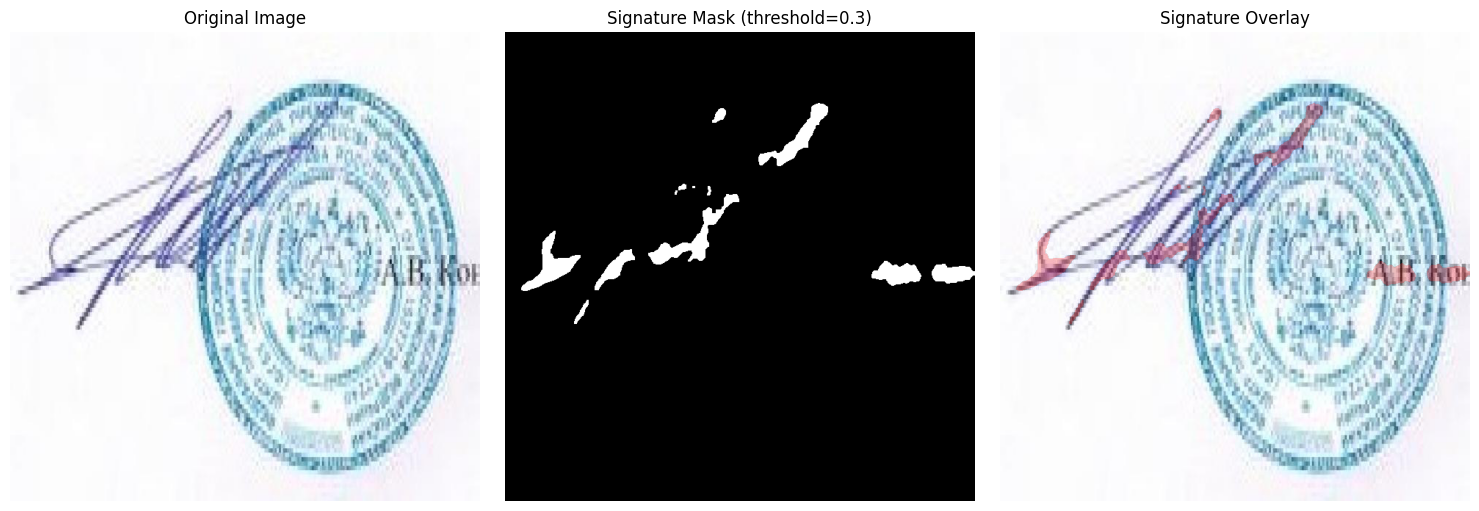

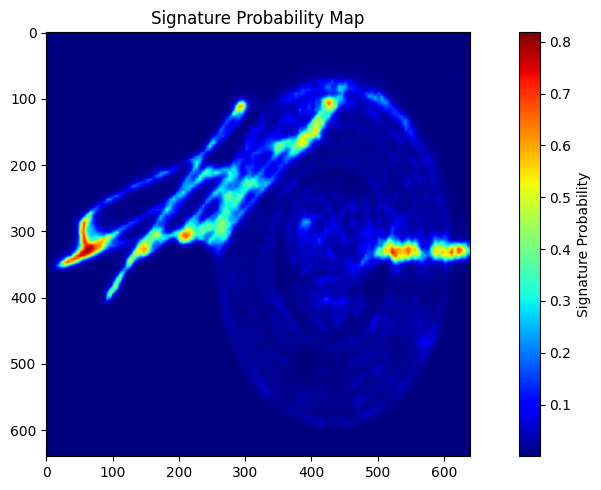

Signature mask saved to signature_mask_threshold_0.3.png


In [12]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import torch.nn.functional as F


def segment_signature(model, image_path, feature_extractor, confidence_threshold=0.5, output_path=None, visualize=True):
    """
    Run signature segmentation on an image with confidence threshold
    
    Args:
        model: Loaded SegformerForSemanticSegmentation model
        image_path: Path to the input image
        feature_extractor: SegformerFeatureExtractor for preprocessing
        confidence_threshold: Minimum probability to consider a pixel as signature (0.0-1.0)
        output_path: Optional path to save the segmentation mask
        visualize: Whether to display the results
        
    Returns:
        Binary mask as numpy array (1 where signature is detected, 0 elsewhere)
    """
    # Load image
    image = Image.open(image_path)
    original_size = image.size  # (width, height)
    
    # Preprocess image
    inputs = feature_extractor(images=image, return_tensors="pt")
    
    # Move inputs to the same device as model
    device = next(model.parameters()).device
    pixel_values = inputs.pixel_values.to(device)
    
    # Run inference
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits
    
    # Resize logits to original image size (height, width)
    upsampled_logits = F.interpolate(
        logits, 
        size=(original_size[1], original_size[0]),  # (height, width)
        mode="bilinear",
        align_corners=False
    )
    
    # Get class probabilities
    probabilities = F.softmax(upsampled_logits, dim=1)
    
    # Get probability of signature class (class index 1)
    signature_probability = probabilities[0, 1].cpu().numpy()
    
    # Apply confidence threshold to create binary mask
    seg_map = (signature_probability > confidence_threshold).astype(np.uint8)
    
    # Optional: Apply morphological operations to clean up the mask
    import cv2
    kernel = np.ones((3, 3), np.uint8)
    seg_map = cv2.morphologyEx(seg_map, cv2.MORPH_OPEN, kernel)   # Remove noise
    seg_map = cv2.morphologyEx(seg_map, cv2.MORPH_CLOSE, kernel)  # Fill small holes
    
    # Visualize if requested
    if visualize:
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(seg_map, cmap='gray')
        plt.title(f"Signature Mask (threshold={confidence_threshold})")
        plt.axis('off')
        
        # Create a colored overlay
        overlay = np.zeros((original_size[1], original_size[0], 4), dtype=np.uint8)
        overlay[seg_map == 1] = [255, 0, 0, 128]  # Red with 50% transparency where signature is
        
        plt.subplot(1, 3, 3)
        plt.imshow(image)
        plt.imshow(overlay, alpha=0.5)
        plt.title("Signature Overlay")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Also show the raw probability map to help with threshold tuning
        plt.figure(figsize=(10, 5))
        plt.imshow(signature_probability, cmap='jet')
        plt.colorbar(label='Signature Probability')
        plt.title('Signature Probability Map')
        plt.tight_layout()
        plt.show()
    
    # Save output if requested
    if output_path:
        # Save as binary PNG (255 for signature, 0 for background)
        binary_mask = (seg_map * 255).astype(np.uint8)
        mask_image = Image.fromarray(binary_mask)
        mask_image.save(output_path)
        print(f"Signature mask saved to {output_path}")
    
    return seg_map

# Example usage
if __name__ == "__main__":
    import torch
    from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
    
    # 1. Load the feature extractor
    feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
    feature_extractor.do_reduce_labels = False
    
    # 2. Load your signature segmentation model
    model_path = "segformer_best_model.pth"
    
    # Define the class mapping
    id2label = {0: "background", 1: "signature"}
    label2id = {v:k for k,v in id2label.items()}
    
    # Initialize the model architecture
    model = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/segformer-b0-finetuned-ade-512-512",
        return_dict=True,
        num_labels=2,  # background and signature
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True,
    )
    
    # Load the saved weights
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Move to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # 3. Run inference with different confidence thresholds to find optimal value
    image_path = r"C:\Users\shiva\Desktop\AIQOD\nalla-5\train\-_-_-__-_2_box1_stamp_0-79_jpg.rf.01cafb891554b26e0dfe1f3bf9ff76d6.jpg"
    
    # Try different confidence thresholds
    for threshold in [0.3]:
        print(f"\nTrying threshold: {threshold}")
        signature_mask = segment_signature(
            model=model,
            image_path=image_path,
            feature_extractor=feature_extractor,
            confidence_threshold=threshold,
            output_path=f"signature_mask_threshold_{threshold}.png",
            visualize=True
        )

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`


Processing image: -001_box1_stamp_0-61_jpg.rf.cb11d0a6e63210b1e4e5ede67ef75ee1.jpg
Trying threshold: 0.3


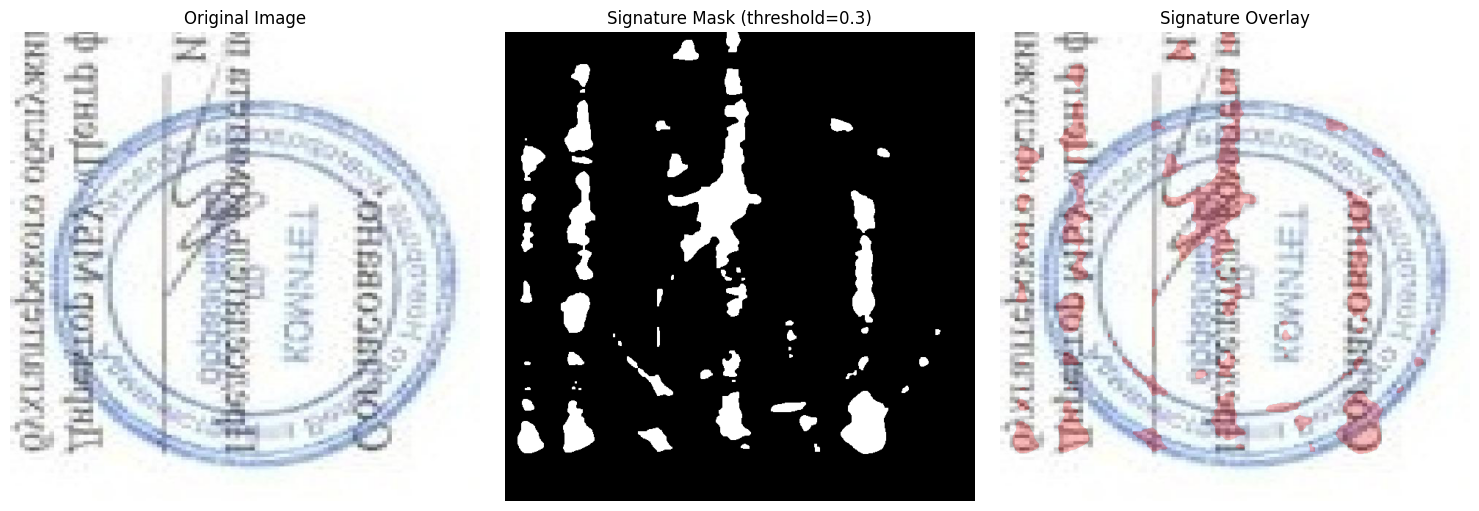

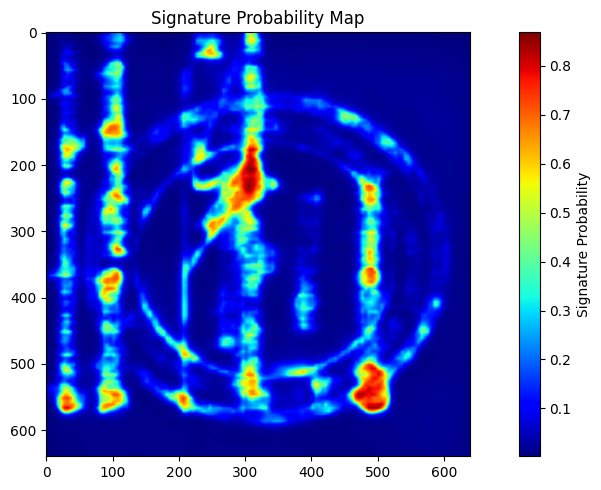

Signature mask saved to -001_box1_stamp_0-61_jpg.rf.cb11d0a6e63210b1e4e5ede67ef75ee1.jpg_signature_mask_threshold_0.3.png

Processing image: -_-_-_-_-_001_box2_stamp_0-47_jpg.rf.5ac30a35ac0378048c7ed100196398c9.jpg
Trying threshold: 0.3


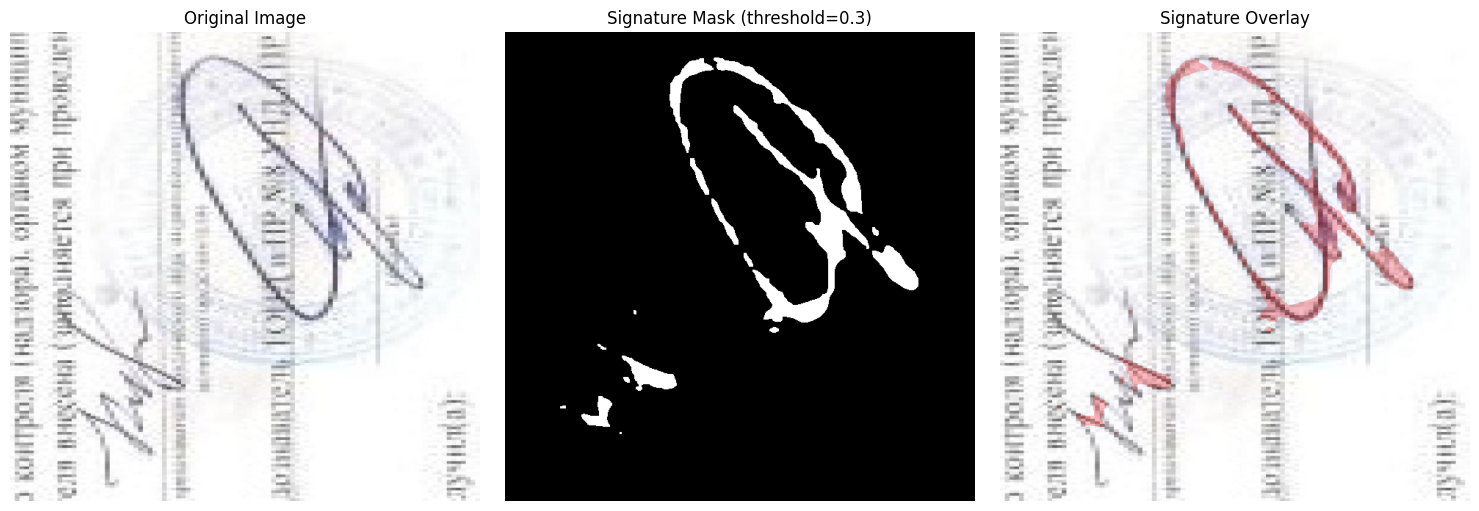

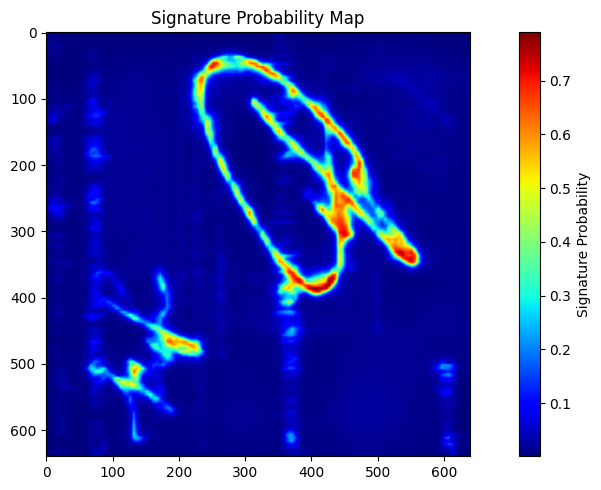

Signature mask saved to -_-_-_-_-_001_box2_stamp_0-47_jpg.rf.5ac30a35ac0378048c7ed100196398c9.jpg_signature_mask_threshold_0.3.png

Processing image: -_-_-__-_2_box1_stamp_0-79_jpg.rf.01cafb891554b26e0dfe1f3bf9ff76d6.jpg
Trying threshold: 0.3


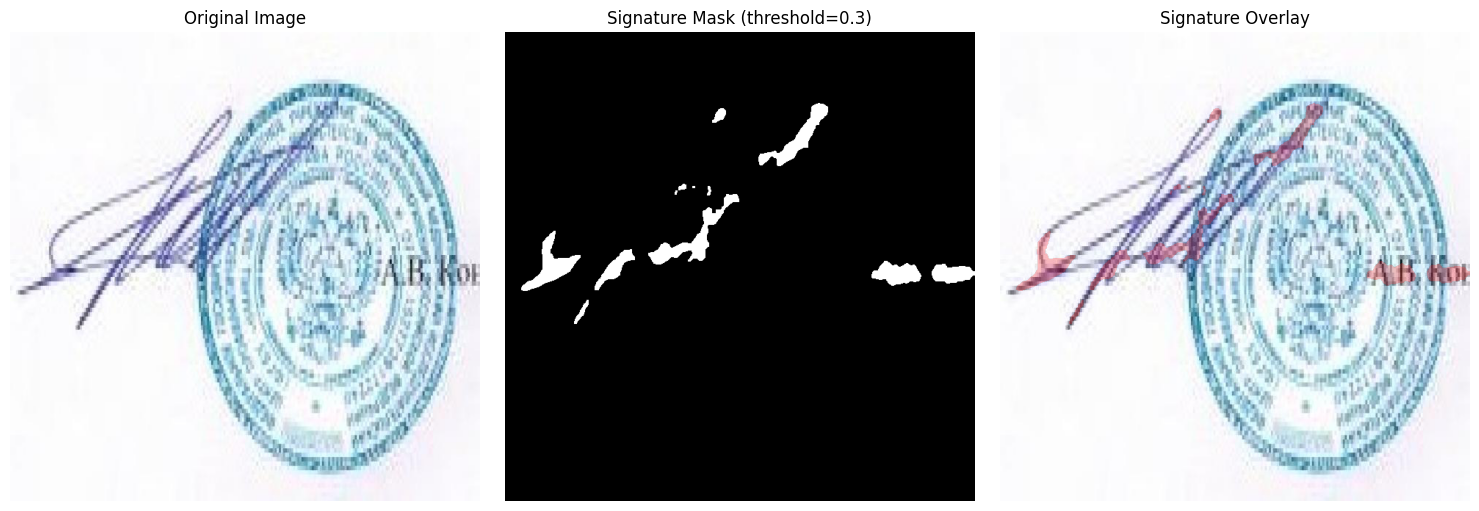

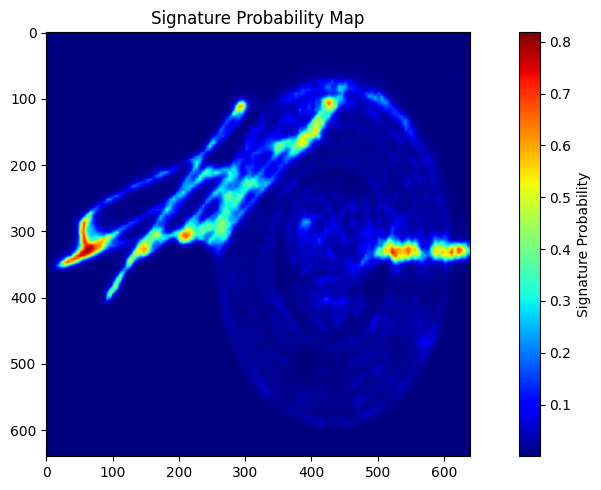

Signature mask saved to -_-_-__-_2_box1_stamp_0-79_jpg.rf.01cafb891554b26e0dfe1f3bf9ff76d6.jpg_signature_mask_threshold_0.3.png

Processing image: -_-_-_-_-_001_box1_stamp_0-67_jpg.rf.63eba629b2e4d503c1130a3dfb1977ee.jpg
Trying threshold: 0.3


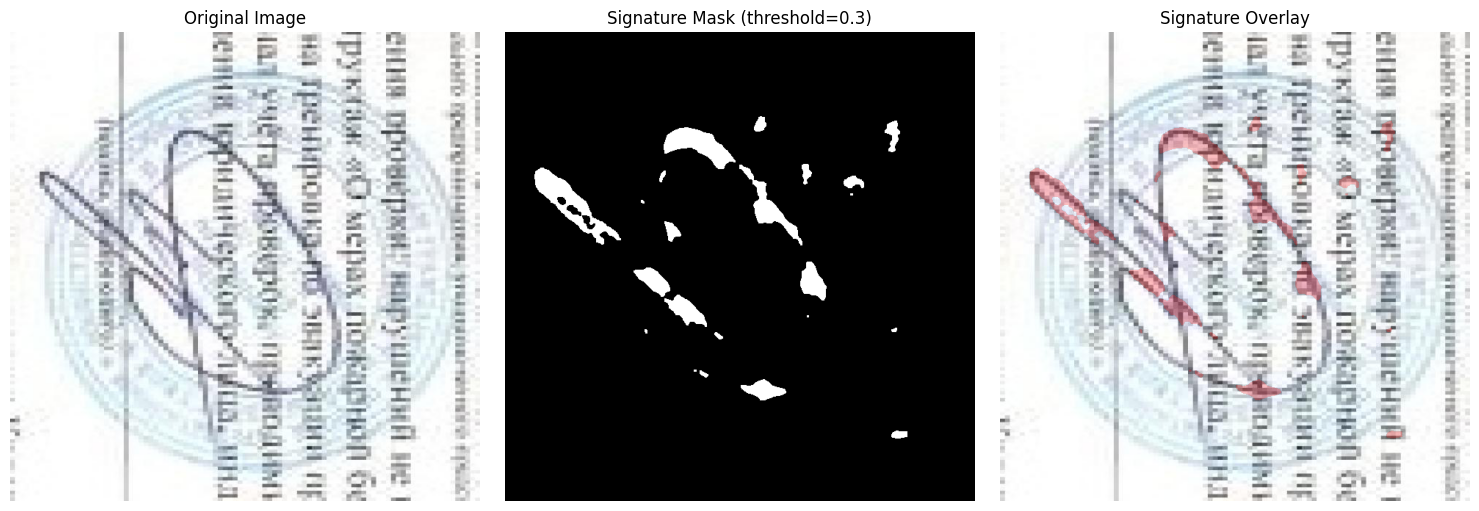

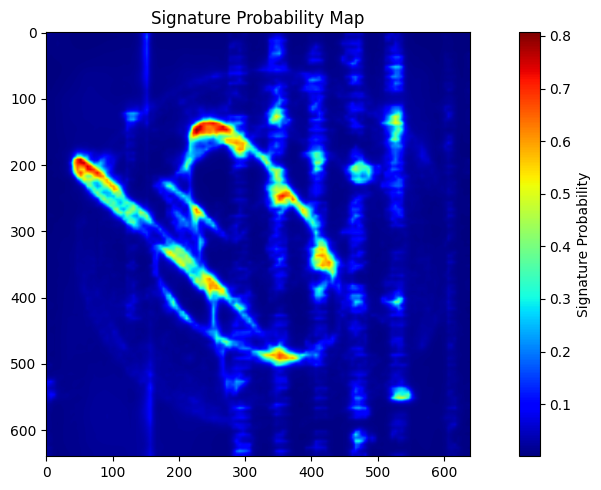

Signature mask saved to -_-_-_-_-_001_box1_stamp_0-67_jpg.rf.63eba629b2e4d503c1130a3dfb1977ee.jpg_signature_mask_threshold_0.3.png

Processing image: -1-1-_box1_stamp_0-76_jpg.rf.920d1b4b9135c4fca8d42a248d3b5d48.jpg
Trying threshold: 0.3


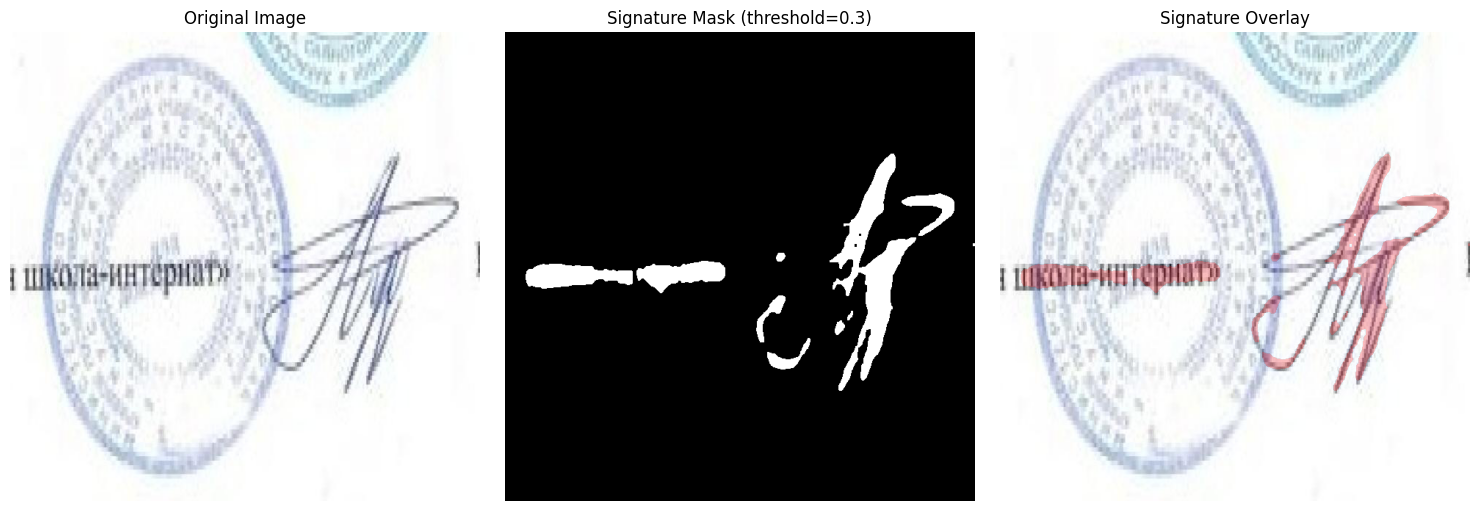

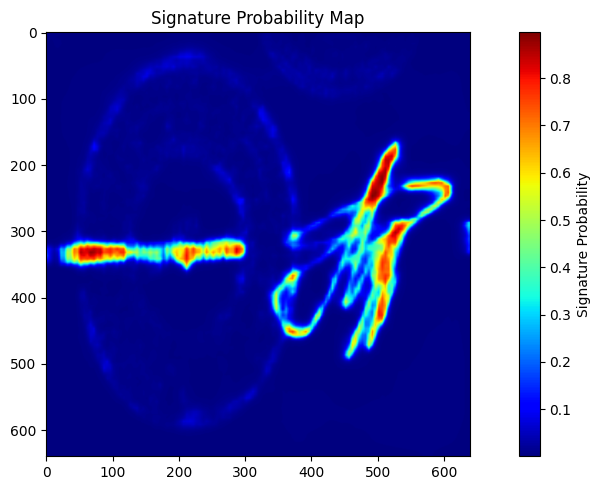

Signature mask saved to -1-1-_box1_stamp_0-76_jpg.rf.920d1b4b9135c4fca8d42a248d3b5d48.jpg_signature_mask_threshold_0.3.png


In [15]:
import os
import random
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import torch.nn.functional as F

# Function to load and process each image
def segment_signature(model, image_path, feature_extractor, confidence_threshold=0.5, output_path=None, visualize=True):
    """
    Run signature segmentation on an image with confidence threshold
    
    Args:
        model: Loaded SegformerForSemanticSegmentation model
        image_path: Path to the input image
        feature_extractor: SegformerFeatureExtractor for preprocessing
        confidence_threshold: Minimum probability to consider a pixel as signature (0.0-1.0)
        output_path: Optional path to save the segmentation mask
        visualize: Whether to display the results
        
    Returns:
        Binary mask as numpy array (1 where signature is detected, 0 elsewhere)
    """
    # Load image and ensure it's RGB
    image = Image.open(image_path).convert('RGB')
    original_size = image.size  # (width, height)
    
    # Preprocess image
    inputs = feature_extractor(images=image, return_tensors="pt")
    
    # Move inputs to the same device as model
    device = next(model.parameters()).device
    pixel_values = inputs.pixel_values.to(device)
    
    # Run inference
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits
    
    # Resize logits to original image size (height, width)
    upsampled_logits = F.interpolate(
        logits, 
        size=(original_size[1], original_size[0]),  # (height, width)
        mode="bilinear",
        align_corners=False
    )
    
    # Get class probabilities
    probabilities = F.softmax(upsampled_logits, dim=1)
    
    # Get probability of signature class (class index 1)
    signature_probability = probabilities[0, 1].cpu().numpy()
    
    # Apply confidence threshold to create binary mask
    seg_map = (signature_probability > confidence_threshold).astype(np.uint8)
    
    # Optional: Apply morphological operations to clean up the mask
    import cv2
    kernel = np.ones((3, 3), np.uint8)
    seg_map = cv2.morphologyEx(seg_map, cv2.MORPH_OPEN, kernel)   # Remove noise
    seg_map = cv2.morphologyEx(seg_map, cv2.MORPH_CLOSE, kernel)  # Fill small holes
    
    # Visualize if requested
    if visualize:
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(seg_map, cmap='gray')
        plt.title(f"Signature Mask (threshold={confidence_threshold})")
        plt.axis('off')
        
        # Create a colored overlay
        overlay = np.zeros((original_size[1], original_size[0], 4), dtype=np.uint8)
        overlay[seg_map == 1] = [255, 0, 0, 128]  # Red with 50% transparency where signature is
        
        plt.subplot(1, 3, 3)
        plt.imshow(image)
        plt.imshow(overlay, alpha=0.5)
        plt.title("Signature Overlay")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Also show the raw probability map to help with threshold tuning
        plt.figure(figsize=(10, 5))
        plt.imshow(signature_probability, cmap='jet')
        plt.colorbar(label='Signature Probability')
        plt.title('Signature Probability Map')
        plt.tight_layout()
        plt.show()
    
    # Save output if requested
    if output_path:
        # Save as binary PNG (255 for signature, 0 for background)
        binary_mask = (seg_map * 255).astype(np.uint8)
        mask_image = Image.fromarray(binary_mask)
        mask_image.save(output_path)
        print(f"Signature mask saved to {output_path}")
    
    return seg_map


# Example usage
if __name__ == "__main__":
    import torch
    from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
    
    # 1. Load the feature extractor
    feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
    feature_extractor.do_reduce_labels = False
    
    # 2. Load your signature segmentation model
    model_path = "segformer_best_model.pth"
    
    # Define the class mapping
    id2label = {0: "background", 1: "signature"}
    label2id = {v:k for k,v in id2label.items()}
    
    # Initialize the model architecture
    model = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/segformer-b0-finetuned-ade-512-512",
        return_dict=True,
        num_labels=2,  # background and signature
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True,
    )
    
    # Load the saved weights
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Move to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # 3. Get list of all images in the folder
    image_folder = r"C:\Users\shiva\Desktop\AIQOD\TEST_FOLDER"  # Change to the folder with images
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    
    # 4. Randomly select 5 images from the folder
    selected_images = random.sample(image_files, 5)
    
    # 5. Process each image
    for image_filename in selected_images:
        image_path = os.path.join(image_folder, image_filename)
        print(f"\nProcessing image: {image_filename}")
        
        # Try different confidence thresholds
        for threshold in [0.3]:
            print(f"Trying threshold: {threshold}")
            signature_mask = segment_signature(
                model=model,
                image_path=image_path,
                feature_extractor=feature_extractor,
                confidence_threshold=threshold,
                output_path=f"{image_filename}_signature_mask_threshold_{threshold}.png",
                visualize=True
            )


In [16]:
def extract_segmented_region(image, mask):
    # Convert to numpy arrays
    img_array = np.array(image)
    mask_array = np.array(mask)
    
    # Create a binary mask (1 where segmented, 0 elsewhere)
    binary_mask = np.any(mask_array[:, :, :3] > 50, axis=2).astype(np.uint8)
    
    # Create output image with transparency
    if img_array.shape[2] == 4:  # RGBA
        result = np.zeros_like(img_array)
        result[:, :, :3] = img_array[:, :, :3]  # Copy RGB channels
        result[:, :, 3] = binary_mask * 255  # Set alpha channel based on the mask
    else:  # RGB
        result = np.zeros(img_array.shape[:2] + (4,), dtype=np.uint8)
        result[:, :, :3] = img_array  # Copy RGB channels
        result[:, :, 3] = binary_mask * 255  # Set alpha channel
    
    return Image.fromarray(result)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`


Processing image: -_-_-_-_-_001_box1_stamp_0-73_jpg.rf.440de5bd1df1e8fe1e266868b1db6b29.jpg
Trying threshold: 0.3


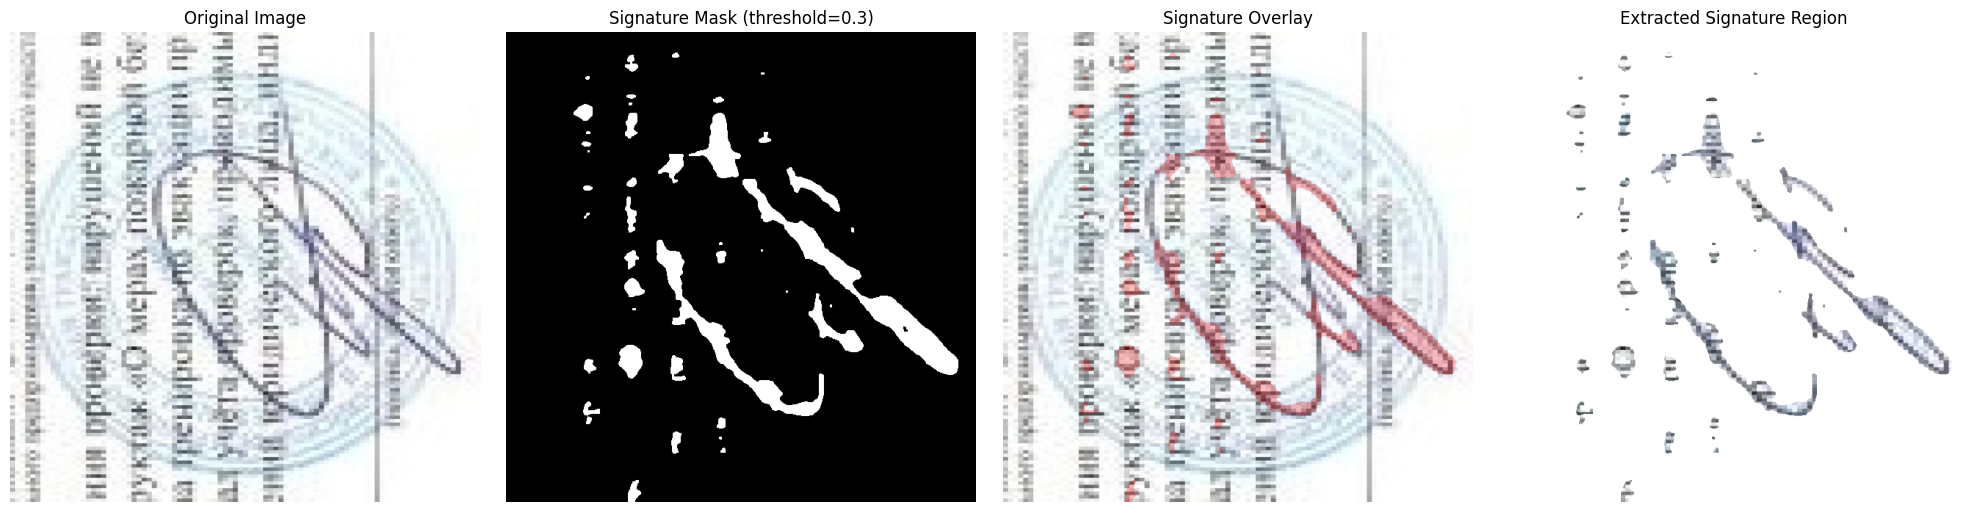

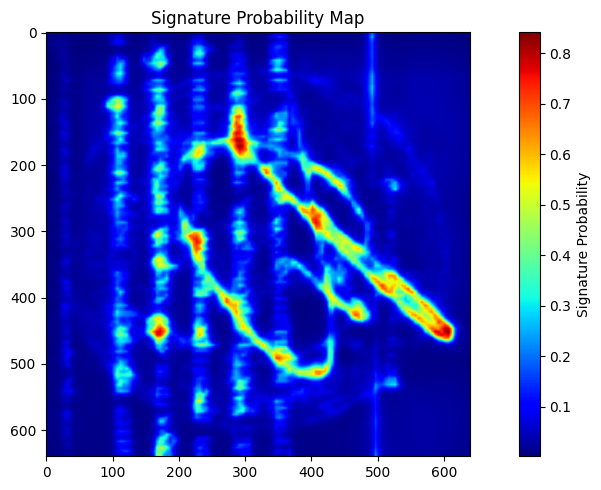

Signature mask saved to -_-_-_-_-_001_box1_stamp_0-73_jpg.rf.440de5bd1df1e8fe1e266868b1db6b29.jpg_signature_mask_threshold_0.3.png

Processing image: -001_box1_stamp_0-61_jpg.rf.cb11d0a6e63210b1e4e5ede67ef75ee1.jpg
Trying threshold: 0.3


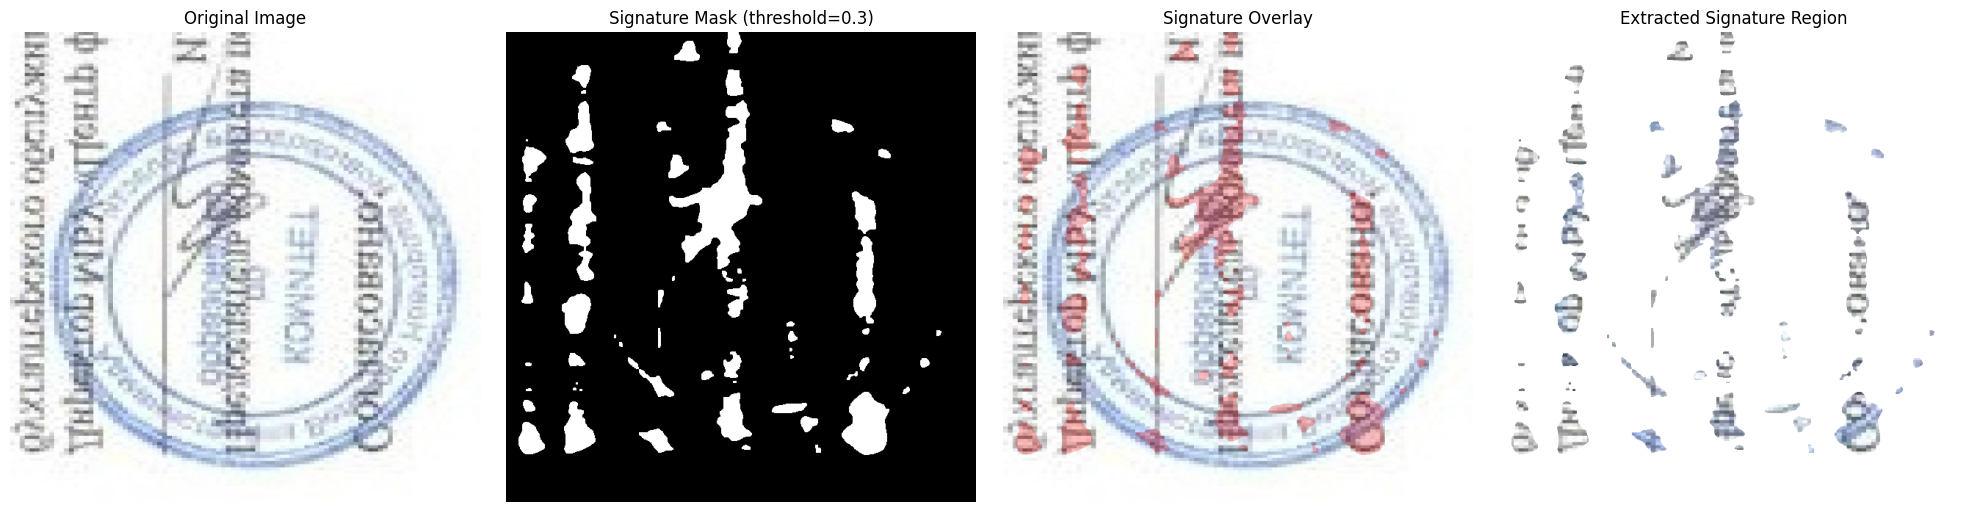

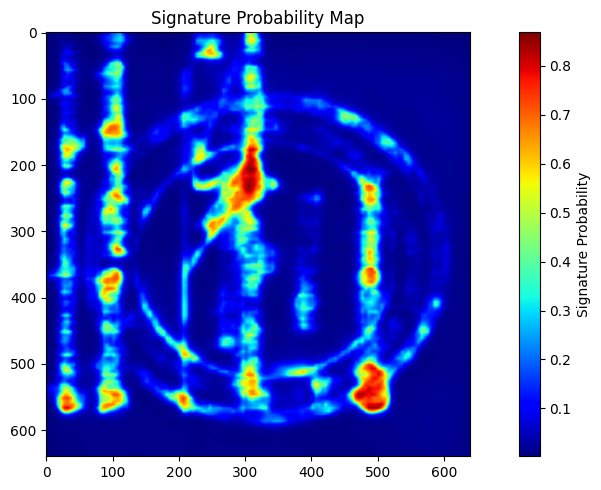

Signature mask saved to -001_box1_stamp_0-61_jpg.rf.cb11d0a6e63210b1e4e5ede67ef75ee1.jpg_signature_mask_threshold_0.3.png

Processing image: -_-_-_-_-_-_box1_stamp_0-55_jpg.rf.b4146e0178690852bc023922dff9a09f.jpg
Trying threshold: 0.3


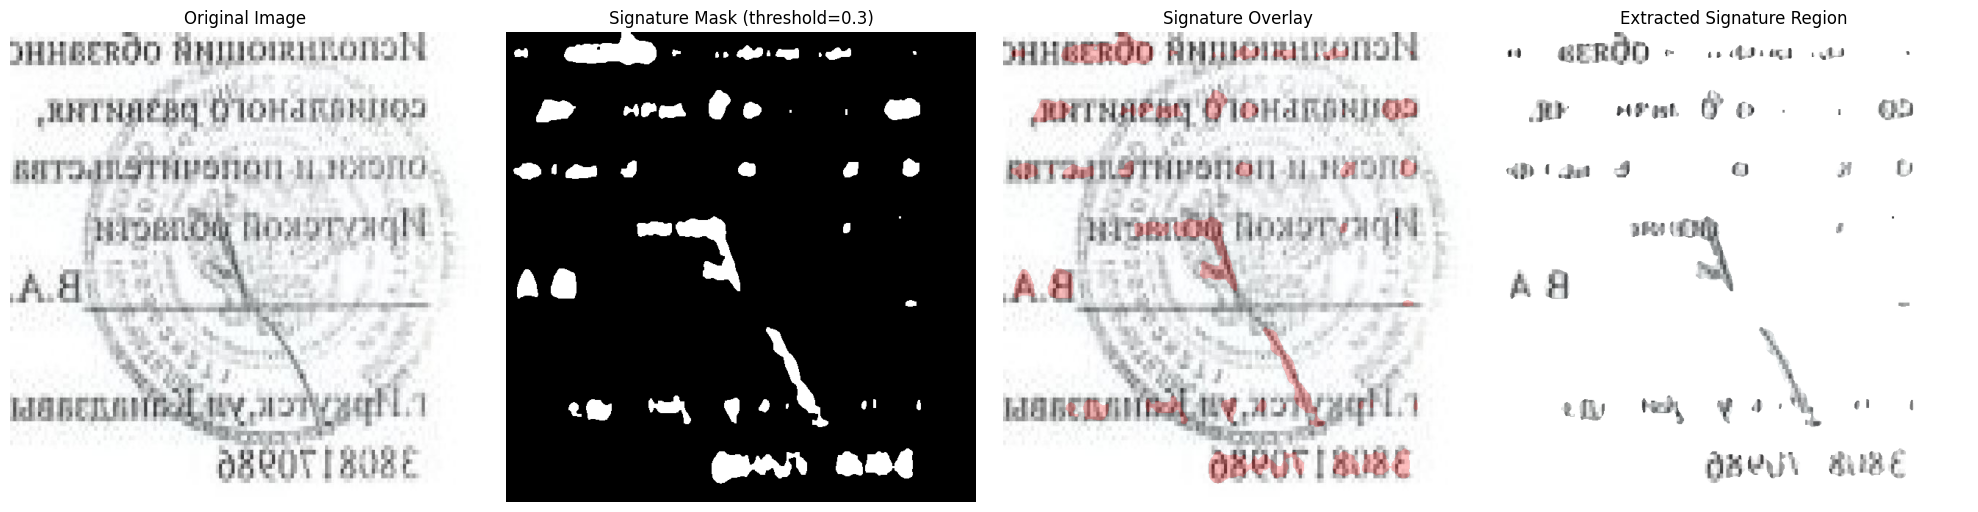

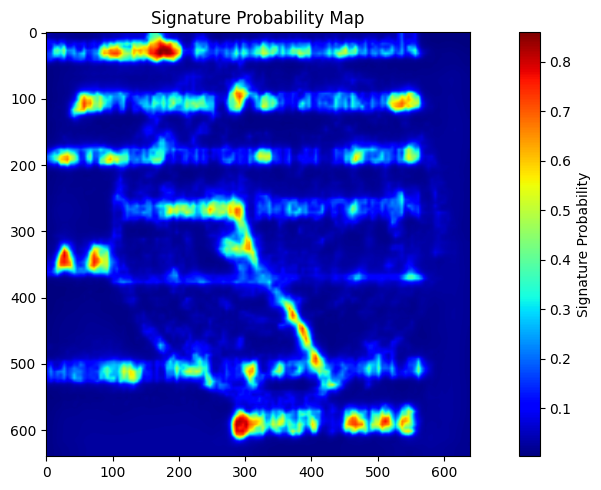

Signature mask saved to -_-_-_-_-_-_box1_stamp_0-55_jpg.rf.b4146e0178690852bc023922dff9a09f.jpg_signature_mask_threshold_0.3.png

Processing image: -_-_-_-_-_001_box1_stamp_0-77_jpg.rf.9095e342ef41ccb7e39ae746c60b7339.jpg
Trying threshold: 0.3


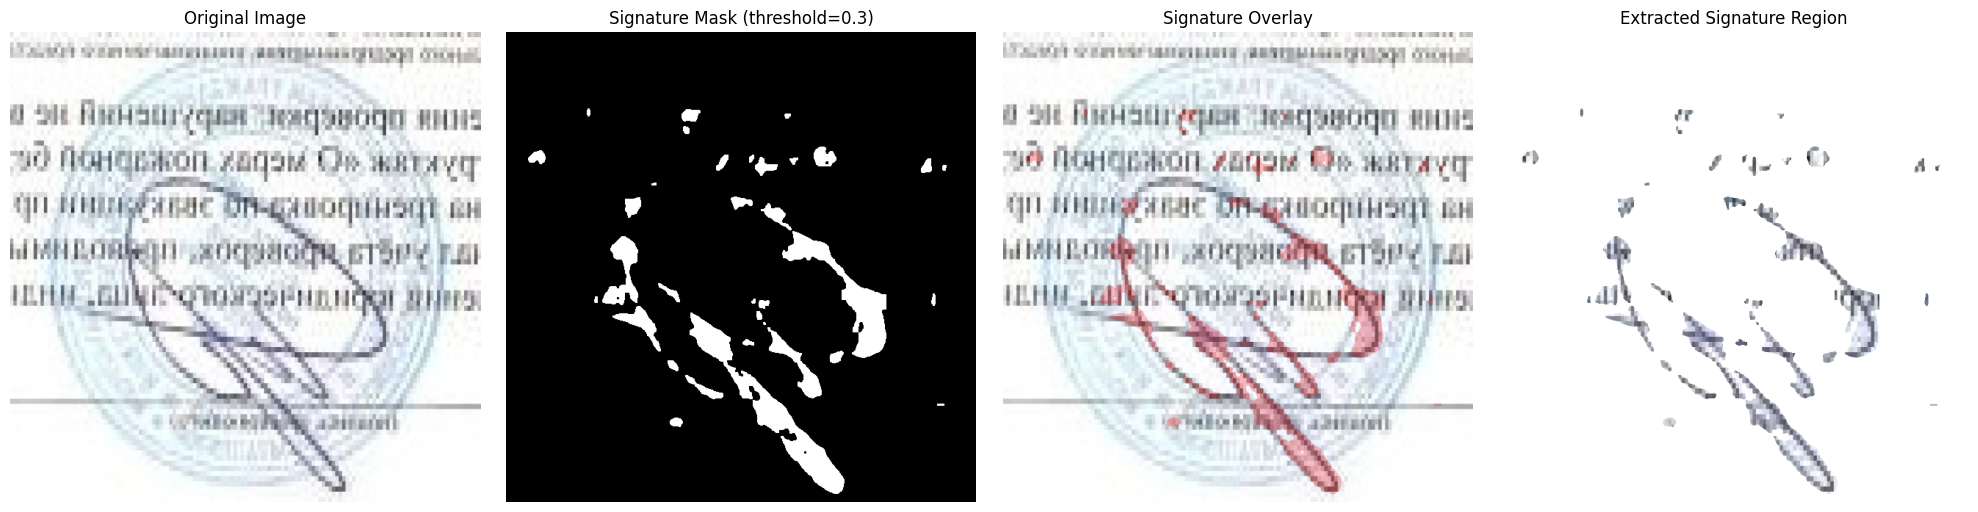

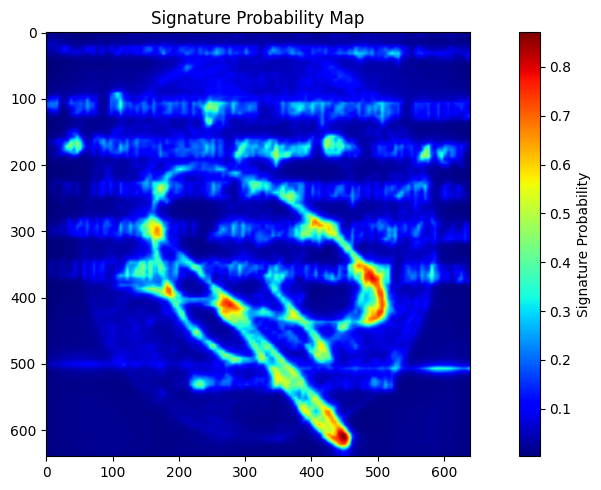

Signature mask saved to -_-_-_-_-_001_box1_stamp_0-77_jpg.rf.9095e342ef41ccb7e39ae746c60b7339.jpg_signature_mask_threshold_0.3.png

Processing image: -_-_-__-_2_box1_stamp_0-79_jpg.rf.01cafb891554b26e0dfe1f3bf9ff76d6.jpg
Trying threshold: 0.3


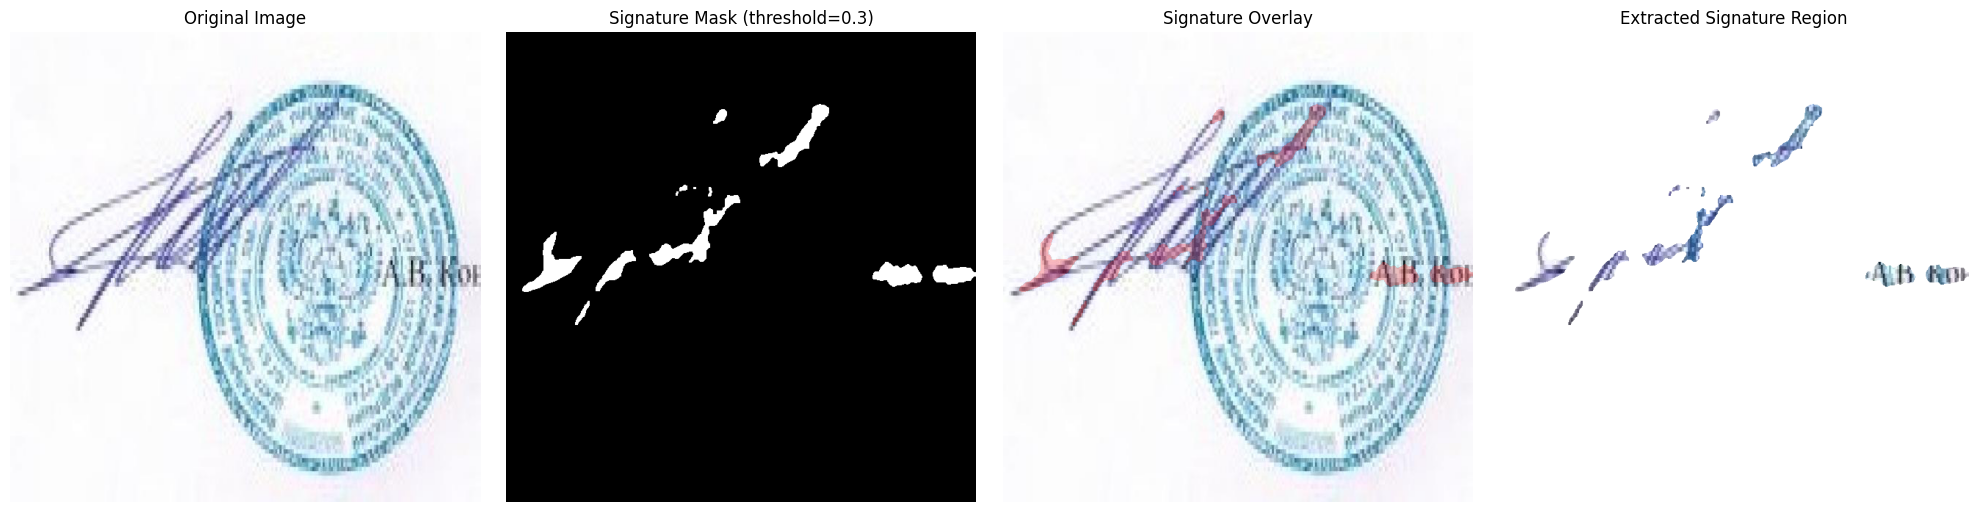

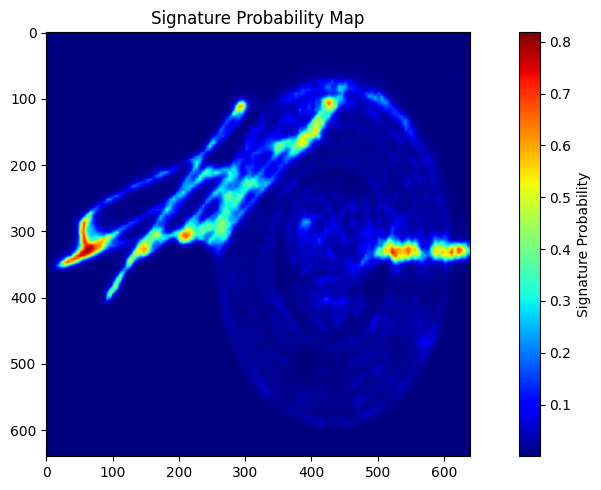

Signature mask saved to -_-_-__-_2_box1_stamp_0-79_jpg.rf.01cafb891554b26e0dfe1f3bf9ff76d6.jpg_signature_mask_threshold_0.3.png


In [24]:
def segment_signature(model, image_path, feature_extractor, confidence_threshold=0.5, output_path=None, visualize=True):
    """
    Run signature segmentation on an image with confidence threshold
    
    Args:
        model: Loaded SegformerForSemanticSegmentation model
        image_path: Path to the input image
        feature_extractor: SegformerFeatureExtractor for preprocessing
        confidence_threshold: Minimum probability to consider a pixel as signature (0.0-1.0)
        output_path: Optional path to save the segmentation mask
        visualize: Whether to display the results
        
    Returns:
        Binary mask as numpy array (1 where signature is detected, 0 elsewhere)
        Extracted segmented region as PIL Image
    """
    # Load image and ensure it's RGB
    image = Image.open(image_path).convert('RGB')
    original_size = image.size  # (width, height)
    
    # Preprocess image
    inputs = feature_extractor(images=image, return_tensors="pt")
    
    # Move inputs to the same device as model
    device = next(model.parameters()).device
    pixel_values = inputs.pixel_values.to(device)
    
    # Run inference
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits
    
    # Resize logits to original image size (height, width)
    upsampled_logits = F.interpolate(
        logits, 
        size=(original_size[1], original_size[0]),  # (height, width)
        mode="bilinear",
        align_corners=False
    )
    
    # Get class probabilities
    probabilities = F.softmax(upsampled_logits, dim=1)
    
    # Get probability of signature class (class index 1)
    signature_probability = probabilities[0, 1].cpu().numpy()
    
    # Apply confidence threshold to create binary mask
    seg_map = (signature_probability > confidence_threshold).astype(np.uint8)
    
    # Optional: Apply morphological operations to clean up the mask
    import cv2
    kernel = np.ones((3, 3), np.uint8)
    seg_map = cv2.morphologyEx(seg_map, cv2.MORPH_OPEN, kernel)   # Remove noise
    seg_map = cv2.morphologyEx(seg_map, cv2.MORPH_CLOSE, kernel)  # Fill small holes
    
    # Extract the segmented region
    extracted_region = extract_segmented_region(image, seg_map)
    
    # Visualize if requested
    if visualize:
        plt.figure(figsize=(20, 5))
        
        plt.subplot(1, 4, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis('off')
        
        plt.subplot(1, 4, 2)
        plt.imshow(seg_map, cmap='gray')
        plt.title(f"Signature Mask (threshold={confidence_threshold})")
        plt.axis('off')
        
        # Create a colored overlay
        overlay = np.zeros((original_size[1], original_size[0], 4), dtype=np.uint8)
        overlay[seg_map == 1] = [255, 0, 0, 128]  # Red with 50% transparency where signature is
        
        plt.subplot(1, 4, 3)
        plt.imshow(image)
        plt.imshow(overlay, alpha=0.5)
        plt.title("Signature Overlay")
        plt.axis('off')
        
        plt.subplot(1, 4, 4)
        plt.imshow(extracted_region)
        plt.title("Extracted Signature Region")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Also show the raw probability map to help with threshold tuning
        plt.figure(figsize=(10, 5))
        plt.imshow(signature_probability, cmap='jet')
        plt.colorbar(label='Signature Probability')
        plt.title('Signature Probability Map')
        plt.tight_layout()
        plt.show()
    
    # Save output if requested
    if output_path:
        # Save as binary PNG (255 for signature, 0 for background)
        binary_mask = (seg_map * 255).astype(np.uint8)
        mask_image = Image.fromarray(binary_mask)
        mask_image.save(output_path)
        print(f"Signature mask saved to {output_path}")
    
    return seg_map, extracted_region


def extract_segmented_region(image, mask):
    """
    Extract the segmented region from the image using the mask.
    
    Args:
        image: PIL Image (RGB or RGBA)
        mask: Binary mask (numpy array) where 1 indicates the segmented region
        
    Returns:
        Extracted region as PIL Image with transparency
    """
    # Convert to numpy arrays
    img_array = np.array(image)
    mask_array = np.array(mask)
    
    # Create a binary mask (1 where segmented, 0 elsewhere)
    binary_mask = mask_array.astype(np.uint8)
    
    # Create output image with transparency
    if img_array.shape[2] == 4:  # RGBA
        result = np.zeros_like(img_array)
        result[:, :, :3] = img_array[:, :, :3]  # Copy RGB channels
        result[:, :, 3] = binary_mask * 255  # Set alpha channel based on the mask
    else:  # RGB
        result = np.zeros(img_array.shape[:2] + (4,), dtype=np.uint8)
        result[:, :, :3] = img_array  # Copy RGB channels
        result[:, :, 3] = binary_mask * 255  # Set alpha channel
    
    return Image.fromarray(result)


# Example usage
if __name__ == "__main__":
    import torch
    from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
    
    # 1. Load the feature extractor
    feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
    feature_extractor.do_reduce_labels = False
    
    # 2. Load your signature segmentation model
    model_path = "segformer_best_model.pth"
    
    # Define the class mapping
    id2label = {0: "background", 1: "signature"}
    label2id = {v:k for k,v in id2label.items()}
    
    # Initialize the model architecture
    model = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/segformer-b0-finetuned-ade-512-512",
        return_dict=True,
        num_labels=2,  # background and signature
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True,
    )
    
    # Load the saved weights
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Move to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # 3. Get list of all images in the folder
    image_folder = r"C:\Users\shiva\Desktop\AIQOD\TEST_FOLDER"  # Change to the folder with images
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    
    # 4. Randomly select 5 images from the folder
    selected_images = random.sample(image_files, 5)
    
    # 5. Process each image
    for image_filename in selected_images:
        image_path = os.path.join(image_folder, image_filename)
        print(f"\nProcessing image: {image_filename}")
        
        # Try different confidence thresholds
        for threshold in [0.3]:
            print(f"Trying threshold: {threshold}")
            signature_mask, extracted_region = segment_signature(
                model=model,
                image_path=image_path,
                feature_extractor=feature_extractor,
                confidence_threshold=threshold,
                output_path=f"{image_filename}_signature_mask_threshold_{threshold}.png",
                visualize=True
            )

In [26]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
from PIL import Image
import cv2
import random

def segment_signature(model, image_path, feature_extractor, confidence_threshold=0.5, output_folder="results"):
    """
    Run signature segmentation on an image with confidence threshold and save plots in the specified folder.
    
    Args:
        model: Loaded SegformerForSemanticSegmentation model.
        image_path: Path to the input image.
        feature_extractor: SegformerFeatureExtractor for preprocessing.
        confidence_threshold: Minimum probability to consider a pixel as signature (0.0-1.0).
        output_folder: Folder to save the segmentation outputs.
        
    Returns:
        seg_map: Binary mask as a numpy array.
        extracted_region: Extracted segmented region as a PIL Image.
    """
    # Create results directory if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Load image and ensure it's RGB
    image = Image.open(image_path).convert('RGB')
    original_size = image.size  # (width, height)
    
    # Preprocess image
    inputs = feature_extractor(images=image, return_tensors="pt")
    
    # Move inputs to the same device as model
    device = next(model.parameters()).device
    pixel_values = inputs.pixel_values.to(device)
    
    # Run inference
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits
    
    # Resize logits to original image size (height, width)
    upsampled_logits = F.interpolate(
        logits, 
        size=(original_size[1], original_size[0]),  # (height, width)
        mode="bilinear",
        align_corners=False
    )
    
    # Get class probabilities
    probabilities = F.softmax(upsampled_logits, dim=1)
    
    # Get probability of signature class (class index 1)
    signature_probability = probabilities[0, 1].cpu().numpy()
    
    # Apply confidence threshold to create binary mask
    seg_map = (signature_probability > confidence_threshold).astype(np.uint8)
    
    # Apply morphological operations to clean up the mask
    kernel = np.ones((3, 3), np.uint8)
    seg_map = cv2.morphologyEx(seg_map, cv2.MORPH_OPEN, kernel)   # Remove noise
    seg_map = cv2.morphologyEx(seg_map, cv2.MORPH_CLOSE, kernel)    # Fill small holes
    
    # Extract the segmented region
    extracted_region = extract_segmented_region(image, seg_map)
    
    # Save visualizations in the output folder
    base_filename = os.path.basename(image_path).split('.')[0]  # Filename without extension
    
    # Save segmentation plots (original, mask, overlay, and extracted region)
    plt.figure(figsize=(20, 5))
    
    # Original Image
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')
    
    # Binary Mask
    plt.subplot(1, 4, 2)
    plt.imshow(seg_map, cmap='gray')
    plt.title(f"Signature Mask (threshold={confidence_threshold})")
    plt.axis('off')
    
    # Overlay on Image
    overlay = np.zeros((original_size[1], original_size[0], 4), dtype=np.uint8)
    overlay[seg_map == 1] = [255, 0, 0, 128]  # Red overlay with 50% transparency
    plt.subplot(1, 4, 3)
    plt.imshow(image)
    plt.imshow(overlay, alpha=0.5)
    plt.title("Signature Overlay")
    plt.axis('off')
    
    # Extracted Signature Region
    plt.subplot(1, 4, 4)
    plt.imshow(extracted_region)
    plt.title("Extracted Signature Region")
    plt.axis('off')
    
    plt.tight_layout()
    segmentation_save_path = os.path.join(output_folder, f"{base_filename}_segmentation.png")
    plt.savefig(segmentation_save_path, bbox_inches='tight')
    plt.close()
    
    # Save the probability map
    plt.figure(figsize=(10, 5))
    plt.imshow(signature_probability, cmap='jet')
    plt.colorbar(label='Signature Probability')
    plt.title('Signature Probability Map')
    probability_map_save_path = os.path.join(output_folder, f"{base_filename}_probability_map.png")
    plt.savefig(probability_map_save_path, bbox_inches='tight')
    plt.close()
    
    print(f"Saved segmentation results for {base_filename} in '{output_folder}' folder.")
    return seg_map, extracted_region

def extract_segmented_region(image, mask):
    """
    Extract the segmented region from the image using the mask.
    
    Args:
        image: PIL Image (RGB or RGBA).
        mask: Binary mask (numpy array) where 1 indicates the segmented region.
        
    Returns:
        Extracted region as a PIL Image with transparency.
    """
    img_array = np.array(image)
    mask_array = np.array(mask)
    
    # Create binary mask (1 where segmented, 0 elsewhere)
    binary_mask = mask_array.astype(np.uint8)
    
    # Create output image with transparency (add alpha channel)
    if img_array.shape[2] == 4:  # RGBA
        result = np.zeros_like(img_array)
        result[:, :, :3] = img_array[:, :, :3]  # Copy RGB channels
        result[:, :, 3] = binary_mask * 255       # Alpha channel based on mask
    else:  # RGB
        result = np.zeros(img_array.shape[:2] + (4,), dtype=np.uint8)
        result[:, :, :3] = img_array               # Copy RGB channels
        result[:, :, 3] = binary_mask * 255        # Alpha channel based on mask
    
    return Image.fromarray(result)

if __name__ == "__main__":
    # Load the feature extractor
    feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
    feature_extractor.do_reduce_labels = False
    
    # Load your signature segmentation model
    model_path = "segformer_best_model.pth"
    
    # Define the class mapping
    id2label = {0: "background", 1: "signature"}
    label2id = {v: k for k, v in id2label.items()}
    
    # Initialize the model architecture
    model = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/segformer-b0-finetuned-ade-512-512",
        return_dict=True,
        num_labels=2,  # background and signature
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True,
    )
    
    # Load the saved weights
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Get list of all images in the folder
    image_folder = r"C:\Users\shiva\Desktop\AIQOD\TEST_FOLDER"  # Change to your images folder
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    
    # Randomly select 5 images from the folder
    selected_images = random.sample(image_files, 5)
    
    # Process each image
    for image_filename in selected_images:
        image_path = os.path.join(image_folder, image_filename)
        print(f"\nProcessing image: {image_filename}")
        
        # For each confidence threshold (example threshold 0.3)
        for threshold in [0.3]:
            print(f"Trying threshold: {threshold}")
            signature_mask, extracted_region = segment_signature(
                model=model,
                image_path=image_path,
                feature_extractor=feature_extractor,
                confidence_threshold=threshold,
                output_folder="results"  # All outputs saved in the 'results' folder
            )


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`


Processing image: -_-_-_-_-_001_box2_stamp_0-47_jpg.rf.5ac30a35ac0378048c7ed100196398c9.jpg
Trying threshold: 0.3
Saved segmentation results for -_-_-_-_-_001_box2_stamp_0-47_jpg in 'results' folder.

Processing image: -001_box1_stamp_0-61_jpg.rf.cb11d0a6e63210b1e4e5ede67ef75ee1.jpg
Trying threshold: 0.3
Saved segmentation results for -001_box1_stamp_0-61_jpg in 'results' folder.

Processing image: -_-_-_-_-_001_box1_stamp_0-77_jpg.rf.df6e25133c97a099aef926af1f92e4d3.jpg
Trying threshold: 0.3
Saved segmentation results for -_-_-_-_-_001_box1_stamp_0-77_jpg in 'results' folder.

Processing image: -_-_-_-_-_001_box2_stamp_0-47_jpg.rf.b0db8a599c9adeb959960e7f274abbaa.jpg
Trying threshold: 0.3
Saved segmentation results for -_-_-_-_-_001_box2_stamp_0-47_jpg in 'results' folder.

Processing image: -_-_-_-_-_-_box1_stamp_0-55_jpg.rf.dc4438edb15ecc64cbebc040b122b928.jpg
Trying threshold: 0.3
Saved segmentation results for -_-_-_-_-_-_box1_stamp_0-55_jpg in 'results' folder.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the original stamp image and the mask image
original_img = cv2.imread('/content/tert1.JPG')
mask_img = cv2.imread('/content/tert2.JPG')

# Print shapes for debugging
print(f"Original image shape: {original_img.shape}")
print(f"Mask image shape: {mask_img.shape}")

# Convert images to RGB format (OpenCV loads in BGR by default)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
mask_img = cv2.cvtColor(mask_img, cv2.COLOR_BGR2RGB)

# Resize mask image to match original image if they have different sizes
if original_img.shape[:2] != mask_img.shape[:2]:
    mask_img = cv2.resize(mask_img, (original_img.shape[1], original_img.shape[0]))
    print(f"Resized mask image to: {mask_img.shape}")

# Convert mask image to HSV for better signature detection
mask_hsv = cv2.cvtColor(mask_img, cv2.COLOR_RGB2HSV)

# Define red color range in HSV
lower_red1 = np.array([0, 100, 120])
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([160, 100, 120])
upper_red2 = np.array([180, 255, 255])

# Create masks for both red ranges
mask1 = cv2.inRange(mask_hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(mask_hsv, lower_red2, upper_red2)

# Combine the masks to get all red regions
signature_mask = cv2.bitwise_or(mask1, mask2)

# Create a very thin dilation kernel - this will expand the mask only slightly
line_kernel = np.array([[0, 1, 0],
                         [1, 1, 1],
                         [0, 1, 0]], dtype=np.uint8)

# Apply minimal dilation - just enough to connect components
signature_mask = cv2.dilate(signature_mask, line_kernel, iterations=1)

# Show the signature mask
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(mask_img)
plt.title('Mask Image with Red Signature')
plt.axis('off')

plt.subplot(122)
plt.imshow(signature_mask, cmap='gray')
plt.title('Signature Mask')
plt.axis('off')
plt.tight_layout()
plt.show()

# METHOD 1: Direct white replacement
# Create a copy of the original image for direct replacement
result_white = original_img.copy()

# Get indices where signature mask is non-zero (signature pixels)
signature_indices = signature_mask > 0

# Replace signature pixels with white
result_white[signature_indices] = [255, 255, 255]  # White color

# METHOD 2: Background color replacement (if you want to match the stamp background)
# Try to get the background color of the stamp
# Sample a few pixels from the image to determine background color
# This assumes the top-left corner is background
bg_sample = original_img[10:20, 10:20].mean(axis=(0, 1)).astype(int)
print(f"Detected background color: RGB{tuple(bg_sample)}")

# Create a copy of the original image for background color replacement
result_bg_color = original_img.copy()

# Replace signature pixels with detected background color
result_bg_color[signature_indices] = bg_sample

# METHOD 3: Create a mask for signature blending with transparency
# Create a transparent area where signature is detected
# First create a white background
white_bg = np.ones_like(original_img) * 255

# Create an inverse mask (0 for signature, 1 for everything else)
inverse_signature_mask = (1 - (signature_mask > 0).astype(np.float32))
inverse_signature_mask_3channel = np.stack([inverse_signature_mask] * 3, axis=2)

# Blend the original image with white using the mask
result_alpha_blend = (original_img * inverse_signature_mask_3channel + 
                      white_bg * (1 - inverse_signature_mask_3channel)).astype(np.uint8)

# Display all results
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.imshow(original_img)
plt.title('Original Stamp')
plt.axis('off')

plt.subplot(222)
plt.imshow(signature_mask, cmap='gray')
plt.title('Signature Mask')
plt.axis('off')

plt.subplot(223)
plt.imshow(result_white)
plt.title('White Replacement')
plt.axis('off')

plt.subplot(224)
plt.imshow(result_bg_color)
plt.title('Background Color Replacement')
plt.axis('off')
plt.tight_layout()
plt.show()

# Display alpha blend result separately
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(original_img)
plt.title('Original Stamp')
plt.axis('off')

plt.subplot(122)
plt.imshow(result_alpha_blend)
plt.title('Alpha Blended Removal')
plt.axis('off')
plt.tight_layout()
plt.show()

# Save all results
cv2.imwrite('stamp_white_replacement.jpg', cv2.cvtColor(result_white, cv2.COLOR_RGB2BGR))
cv2.imwrite('stamp_bg_color_replacement.jpg', cv2.cvtColor(result_bg_color, cv2.COLOR_RGB2BGR))
cv2.imwrite('stamp_alpha_blend.jpg', cv2.cvtColor(result_alpha_blend, cv2.COLOR_RGB2BGR))

print("Processing complete! Saved results as 'stamp_white_replacement.jpg', 'stamp_bg_color_replacement.jpg', and 'stamp_alpha_blend.jpg'")

In [27]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
from PIL import Image
import cv2
import random

def segment_signature(model, image_path, feature_extractor, confidence_threshold=0.5, output_folder="results"):
    """
    Run signature segmentation on an image with a given confidence threshold and save plots in the specified folder.
    
    Args:
        model: Loaded SegformerForSemanticSegmentation model.
        image_path: Path to the input image.
        feature_extractor: SegformerFeatureExtractor for preprocessing.
        confidence_threshold: Minimum probability to consider a pixel as signature (0.0-1.0).
        output_folder: Folder to save the segmentation outputs.
        
    Returns:
        seg_map: Binary mask as a numpy array (values 0 or 1).
        extracted_region: Extracted segmented region as a PIL Image.
    """
    # Create results directory if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Load image (as PIL) and ensure it's RGB
    image = Image.open(image_path).convert('RGB')
    original_size = image.size  # (width, height)
    
    # Preprocess image for segmentation model
    inputs = feature_extractor(images=image, return_tensors="pt")
    
    # Move inputs to the same device as model
    device = next(model.parameters()).device
    pixel_values = inputs.pixel_values.to(device)
    
    # Run inference
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits
    
    # Resize logits to the original image size (height, width)
    upsampled_logits = F.interpolate(
        logits, 
        size=(original_size[1], original_size[0]),
        mode="bilinear",
        align_corners=False
    )
    
    # Get class probabilities
    probabilities = F.softmax(upsampled_logits, dim=1)
    
    # Get probability of signature class (class index 1)
    signature_probability = probabilities[0, 1].cpu().numpy()
    
    # Create binary mask based on the confidence threshold
    seg_map = (signature_probability > confidence_threshold).astype(np.uint8)
    
    # Clean up the mask with morphological operations
    kernel = np.ones((3, 3), np.uint8)
    seg_map = cv2.morphologyEx(seg_map, cv2.MORPH_OPEN, kernel)
    seg_map = cv2.morphologyEx(seg_map, cv2.MORPH_CLOSE, kernel)
    
    # Extract the segmented region (with transparency)
    extracted_region = extract_segmented_region(image, seg_map)
    
    # Save segmentation visualizations
    base_filename = os.path.basename(image_path).split('.')[0]  # Filename without extension
    
    # Composite plot: original image, binary mask, overlay, and extracted region
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(seg_map, cmap='gray')
    plt.title(f"Signature Mask\n(threshold={confidence_threshold})")
    plt.axis('off')
    
    # Create an overlay for the signature (red with 50% transparency)
    overlay = np.zeros((original_size[1], original_size[0], 4), dtype=np.uint8)
    overlay[seg_map == 1] = [255, 0, 0, 128]
    plt.subplot(1, 4, 3)
    plt.imshow(image)
    plt.imshow(overlay, alpha=0.5)
    plt.title("Signature Overlay")
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(extracted_region)
    plt.title("Extracted Signature Region")
    plt.axis('off')
    
    plt.tight_layout()
    segmentation_save_path = os.path.join(output_folder, f"{base_filename}_segmentation.png")
    plt.savefig(segmentation_save_path, bbox_inches='tight')
    plt.close()
    
    # Save the probability map separately
    plt.figure(figsize=(10, 5))
    plt.imshow(signature_probability, cmap='jet')
    plt.colorbar(label='Signature Probability')
    plt.title('Signature Probability Map')
    probability_map_save_path = os.path.join(output_folder, f"{base_filename}_probability_map.png")
    plt.savefig(probability_map_save_path, bbox_inches='tight')
    plt.close()
    
    print(f"Saved segmentation results for {base_filename} in '{output_folder}' folder.")
    return seg_map, extracted_region

def extract_segmented_region(image, mask):
    """
    Extract the segmented region from the image using the mask.
    
    Args:
        image: PIL Image (RGB or RGBA).
        mask: Binary mask (numpy array) where 1 indicates the segmented region.
        
    Returns:
        Extracted region as a PIL Image with transparency.
    """
    img_array = np.array(image)
    binary_mask = mask.astype(np.uint8)
    
    if img_array.shape[2] == 4:  # RGBA
        result = np.zeros_like(img_array)
        result[:, :, :3] = img_array[:, :, :3]
        result[:, :, 3] = binary_mask * 255
    else:  # RGB - add alpha channel
        result = np.zeros(img_array.shape[:2] + (4,), dtype=np.uint8)
        result[:, :, :3] = img_array
        result[:, :, 3] = binary_mask * 255
    
    return Image.fromarray(result)

def remove_signature_methods(image_path, seg_mask, removal_folder="results/removal"):
    """
    Remove the signature from the original image using three different methods.
    
    Args:
        image_path: Path to the original image.
        seg_mask: Binary mask (numpy array) with values 0 or 1.
        removal_folder: Folder to save the removal outputs.
        
    The methods used are:
        1. Direct white replacement.
        2. Background color replacement.
        3. Alpha blending removal.
    """
    os.makedirs(removal_folder, exist_ok=True)
    
    # Load the original image using OpenCV (reads as BGR)
    original_img = cv2.imread(image_path)
    # Convert to RGB for processing and visualization
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    # Convert segmentation mask to 0 or 255 scale
    mask = (seg_mask * 255).astype(np.uint8)
    
    # Ensure mask matches the original image size
    if original_img.shape[:2] != mask.shape:
        mask = cv2.resize(mask, (original_img.shape[1], original_img.shape[0]))
    
    # Method 1: Direct white replacement
    result_white = original_img.copy()
    result_white[mask == 255] = [255, 255, 255]
    
    # Method 2: Background color replacement
    # Sample a region (e.g., top-left corner) to determine the background color
    bg_sample = original_img[10:20, 10:20].mean(axis=(0, 1)).astype(np.uint8)
    result_bg_color = original_img.copy()
    result_bg_color[mask == 255] = bg_sample
    
    # Method 3: Alpha blending removal
    white_bg = np.ones_like(original_img) * 255
    # Create a normalized inverse mask (values 1 where no signature, 0 where signature)
    inverse_mask = (255 - mask) / 255.0
    inverse_mask_3channel = np.stack([inverse_mask] * 3, axis=2)
    result_alpha_blend = (original_img * inverse_mask_3channel + white_bg * (1 - inverse_mask_3channel)).astype(np.uint8)
    
    # Save results (convert to BGR for cv2.imwrite)
    base_filename = os.path.basename(image_path).split('.')[0]
    
    result_white_bgr = cv2.cvtColor(result_white, cv2.COLOR_RGB2BGR)
    result_bg_color_bgr = cv2.cvtColor(result_bg_color, cv2.COLOR_RGB2BGR)
    result_alpha_blend_bgr = cv2.cvtColor(result_alpha_blend, cv2.COLOR_RGB2BGR)
    
    white_save_path = os.path.join(removal_folder, f"{base_filename}_white_replacement.jpg")
    bg_color_save_path = os.path.join(removal_folder, f"{base_filename}_bg_color_replacement.jpg")
    alpha_blend_save_path = os.path.join(removal_folder, f"{base_filename}_alpha_blend.jpg")
    
    cv2.imwrite(white_save_path, result_white_bgr)
    cv2.imwrite(bg_color_save_path, result_bg_color_bgr)
    cv2.imwrite(alpha_blend_save_path, result_alpha_blend_bgr)
    
    print(f"Saved removal results for {base_filename} in '{removal_folder}' folder.")

if __name__ == "__main__":
    from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
    
    # 1. Load the feature extractor and model
    feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
    feature_extractor.do_reduce_labels = False
    
    model_path = "segformer_best_model.pth"
    id2label = {0: "background", 1: "signature"}
    label2id = {v: k for k, v in id2label.items()}
    
    model = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/segformer-b0-finetuned-ade-512-512",
        return_dict=True,
        num_labels=2,
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True,
    )
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # 2. Process all images in the folder
    image_folder = r"C:\Users\shiva\Desktop\AIQOD\TEST_FOLDER"  # Update to your images folder
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    
    for image_filename in image_files:
        image_path = os.path.join(image_folder, image_filename)
        print(f"\nProcessing image: {image_filename}")
        
        # Run segmentation on the image (using a desired threshold, e.g., 0.3)
        threshold = 0.3
        seg_mask, _ = segment_signature(
            model=model,
            image_path=image_path,
            feature_extractor=feature_extractor,
            confidence_threshold=threshold,
            output_folder="results"
        )
        
        # Use the segmentation mask to remove the signature using various methods
        remove_signature_methods(image_path, seg_mask, removal_folder="results/removal")


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`


Processing image: -001_box1_stamp_0-61_jpg.rf.cb11d0a6e63210b1e4e5ede67ef75ee1.jpg
Saved segmentation results for -001_box1_stamp_0-61_jpg in 'results' folder.
Saved removal results for -001_box1_stamp_0-61_jpg in 'results/removal' folder.

Processing image: -001_box1_stamp_0-62_jpg.rf.4ce2de8211d3ca871972bbd0b4775bd0.jpg
Saved segmentation results for -001_box1_stamp_0-62_jpg in 'results' folder.
Saved removal results for -001_box1_stamp_0-62_jpg in 'results/removal' folder.

Processing image: -001_box2_stamp_0-56_jpg.rf.21ee5d3ce6855f4065d6f111e3bb95e1.jpg
Saved segmentation results for -001_box2_stamp_0-56_jpg in 'results' folder.
Saved removal results for -001_box2_stamp_0-56_jpg in 'results/removal' folder.

Processing image: -002_box2_stamp_0-75_jpg.rf.f222fb70dc630657f1c1d27ee0cfa214.jpg
Saved segmentation results for -002_box2_stamp_0-75_jpg in 'results' folder.
Saved removal results for -002_box2_stamp_0-75_jpg in 'results/removal' folder.

Processing image: -1-1-_box1_stamp_

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs/

In [ ]:
# res = trainer.test(ckpt_path="best")

#### Present in Version 1

In [ ]:
color_map = {
    0:(0,0,0),
    1:(255,0,0),
}

def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i,c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8))

for batch in test_dataloader:
    images, masks = batch['pixel_values'], batch['labels']
    outputs = segformer_finetuner.model(images, masks)

    loss, logits = outputs[0], outputs[1]

    upsampled_logits = nn.functional.interpolate(
        logits,
        size=masks.shape[-2:],
        mode="bilinear",
        align_corners=False
    )
    predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()
    masks = masks.cpu().numpy()

n_plots = 4
from matplotlib import pyplot as plt
f, axarr = plt.subplots(n_plots,2)
f.set_figheight(15)
f.set_figwidth(15)
for i in range(n_plots):
    axarr[i,0].imshow(prediction_to_vis(predicted_mask[i,:,:]))
    axarr[i,1].imshow(prediction_to_vis(masks[i,:,:]))


In [ ]:
#Predict on a test image and overlay the mask on the original image
test_idx = 0
input_image_file = os.path.join(test_dataset.root_dir,test_dataset.images[test_idx])
input_image = Image.open(input_image_file)
test_batch = test_dataset[test_idx]
images, masks = test_batch['pixel_values'], test_batch['labels']
images = torch.unsqueeze(images, 0)
masks = torch.unsqueeze(masks, 0)
outputs = segformer_finetuner.model(images, masks)

loss, logits = outputs[0], outputs[1]

upsampled_logits = nn.functional.interpolate(
    logits,
    size=masks.shape[-2:],
    mode="bilinear",
    align_corners=False
)
predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()
mask = prediction_to_vis(np.squeeze(masks))
mask = mask.resize(input_image.size)
mask = mask.convert("RGBA")
input_image = input_image.convert("RGBA")
overlay_img = Image.blend(input_image, mask, 0.5)

In [ ]:
overlay_img

In [ ]:
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

# Iterate through all images in the test dataset
for test_idx in range(len(test_dataset)):
    # Load test image
    input_image_file = os.path.join(test_dataset.root_dir, test_dataset.images[test_idx])
    input_image = Image.open(input_image_file).convert("RGBA")

    # Get test batch
    test_batch = test_dataset[test_idx]
    images, masks = test_batch["pixel_values"], test_batch["labels"]

    # Add batch dimension
    images = torch.unsqueeze(images, 0)
    masks = torch.unsqueeze(masks, 0)

    # Predict using the model
    with torch.no_grad():  # Disable gradient tracking for inference
        outputs = segformer_finetuner.model(images, masks)
        loss, logits = outputs[0], outputs[1]

    # Upsample logits and get predicted mask
    upsampled_logits = nn.functional.interpolate(
        logits,
        size=masks.shape[-2:],
        mode="bilinear",
        align_corners=False
    )
    predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()

    # Convert masks to visualization format
    actual_mask = prediction_to_vis(np.squeeze(masks))
    pred_mask = prediction_to_vis(np.squeeze(predicted_mask))

    # Resize masks to match input image
    actual_mask = actual_mask.resize(input_image.size).convert("RGBA")
    pred_mask = pred_mask.resize(input_image.size).convert("RGBA")

    # Create overlays
    actual_overlay = Image.blend(input_image, actual_mask, alpha=0.5)
    pred_overlay = Image.blend(input_image, pred_mask, alpha=0.5)

    # Display images side by side
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(input_image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(actual_overlay)
    ax[1].set_title("Actual Mask Overlay")
    ax[1].axis("off")

    ax[2].imshow(pred_overlay)
    ax[2].set_title("Predicted Mask Overlay")
    ax[2].axis("off")

    plt.show()


In [ ]:
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

# Iterate through all images in the test dataset
for test_idx in range(len(test_dataset)):
    # Load test image
    input_image_file = os.path.join(test_dataset.root_dir, test_dataset.images[test_idx])
    input_image = Image.open(input_image_file).convert("RGBA")

    # Get test batch
    test_batch = test_dataset[test_idx]
    images, masks = test_batch["pixel_values"], test_batch["labels"]

    # Add batch dimension
    images = torch.unsqueeze(images, 0)
    masks = torch.unsqueeze(masks, 0)

    # Predict using the model
    with torch.no_grad():  # Disable gradient tracking for inference
        outputs = segformer_finetuner.model(images, masks)
        loss, logits = outputs[0], outputs[1]

    # Upsample logits and get predicted mask
    upsampled_logits = nn.functional.interpolate(
        logits,
        size=masks.shape[-2:],
        mode="bilinear",
        align_corners=False
    )
    predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()

    # Convert masks to visualization format
    actual_mask = prediction_to_vis(np.squeeze(masks))
    pred_mask = prediction_to_vis(np.squeeze(predicted_mask))

    # Resize masks to match input image
    actual_mask = actual_mask.resize(input_image.size).convert("RGBA")
    pred_mask = pred_mask.resize(input_image.size).convert("RGBA")

    # Create overlays
    actual_overlay = Image.blend(input_image, actual_mask, alpha=0.5)
    pred_overlay = Image.blend(input_image, pred_mask, alpha=0.5)

    # Display images side by side
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(input_image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(actual_overlay)
    ax[1].set_title("Actual Mask Overlay")
    ax[1].axis("off")

    ax[2].imshow(pred_overlay)
    ax[2].set_title("Predicted Mask Overlay")
    ax[2].axis("off")

    plt.show()


In [ ]:
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

def extract_segmented_region(image, mask):
    """
    Extract the segmented region from the original image based on the mask.
    
    Args:
        image: PIL Image in RGBA format
        mask: PIL Image with segmentation mask
    
    Returns:
        PIL Image with only the segmented region, rest as transparent
    """
    # Convert to numpy arrays
    img_array = np.array(image)
    mask_array = np.array(mask)
    
    # Create a binary mask (1 where segmented, 0 elsewhere)
    binary_mask = np.any(mask_array[:, :, :3] > 50, axis=2).astype(np.uint8)
    
    # Create output image with transparency
    result = np.zeros_like(img_array)
    result[:, :, :3] = img_array[:, :, :3]  # Copy RGB channels
    
    # Set alpha channel based on the mask
    result[:, :, 3] = binary_mask * 255
    
    # Set pixels outside mask to transparent
    result[:, :, 3] *= (binary_mask > 0)
    
    return Image.fromarray(result)

# Iterate through all images in the test dataset
for test_idx in range(len(test_dataset)):
    # Load test image
    input_image_file = os.path.join(test_dataset.root_dir, test_dataset.images[test_idx])
    input_image = Image.open(input_image_file).convert("RGBA")

    # Get test batch
    test_batch = test_dataset[test_idx]
    images, masks = test_batch["pixel_values"], test_batch["labels"]

    # Add batch dimension
    images = torch.unsqueeze(images, 0)
    masks = torch.unsqueeze(masks, 0)

    # Predict using the model
    with torch.no_grad():  # Disable gradient tracking for inference
        outputs = segformer_finetuner.model(images, masks)
        loss, logits = outputs[0], outputs[1]

    # Upsample logits and get predicted mask
    upsampled_logits = nn.functional.interpolate(
        logits,
        size=masks.shape[-2:],
        mode="bilinear",
        align_corners=False
    )
    predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()

    # Convert masks to visualization format
    actual_mask = prediction_to_vis(np.squeeze(masks))
    pred_mask = prediction_to_vis(np.squeeze(predicted_mask))

    # Resize masks to match input image
    actual_mask = actual_mask.resize(input_image.size).convert("RGBA")
    pred_mask = pred_mask.resize(input_image.size).convert("RGBA")

    # Create overlays
    actual_overlay = Image.blend(input_image, actual_mask, alpha=0.5)
    pred_overlay = Image.blend(input_image, pred_mask, alpha=0.5)
    
    # Extract the segmented region based on predicted mask
    segmented_region = extract_segmented_region(input_image, pred_mask)
    
    # Create a white background for better visibility of the segmented region
    white_bg = Image.new("RGBA", input_image.size, (255, 255, 255, 255))
    segmented_with_bg = Image.alpha_composite(white_bg, segmented_region)

    # Display images side by side
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    ax[0].imshow(input_image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(actual_overlay)
    ax[1].set_title("Actual Mask Overlay")
    ax[1].axis("off")

    ax[2].imshow(pred_overlay)
    ax[2].set_title("Predicted Mask Overlay")
    ax[2].axis("off")
    
    ax[3].imshow(segmented_with_bg)
    ax[3].set_title("Extracted Segmented Region")
    ax[3].axis("off")

    plt.tight_layout()
    plt.show()
    
    # Save the segmented region
    output_dir = "segmented_outputs"
    os.makedirs(output_dir, exist_ok=True)
    segmented_region.save(os.path.join(output_dir, f"segmented_{test_idx}.png"))

In [ ]:
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

def extract_segmented_region(image, mask):
    """
    Extract the segmented region from the original image based on the mask.
    
    Args:
        image: PIL Image in RGBA format
        mask: PIL Image with segmentation mask
    
    Returns:
        PIL Image with only the segmented region, rest as transparent
    """
    # Convert to numpy arrays
    img_array = np.array(image)
    mask_array = np.array(mask)
    
    # Create a binary mask (1 where segmented, 0 elsewhere)
    binary_mask = np.any(mask_array[:, :, :3] > 50, axis=2).astype(np.uint8)
    
    # Create output image with transparency
    result = np.zeros_like(img_array)
    result[:, :, :3] = img_array[:, :, :3]  # Copy RGB channels
    
    # Set alpha channel based on the mask
    result[:, :, 3] = binary_mask * 255
    
    # Set pixels outside mask to transparent
    result[:, :, 3] *= (binary_mask > 0)
    
    return Image.fromarray(result)

# Load a single image
image_path = "try.jpg"  # Replace with you image path
input_image = Image.open(image_path).convert("RGBA")

# Prepare the image for model input
# Note: This assumes you have a preprocessing function or method defined elsewhere
# that converts the image to the format expected by the model
from torchvision import transforms

# Define preprocessing - adapt this to match your model's requirements
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),  # Adjust size based on your model's requirements
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Preprocess the image
input_tensor = preprocess(input_image.convert("RGB"))
input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

# Predict using the model
with torch.no_grad():  # Disable gradient tracking for inference
    outputs = segformer_finetuner.model(input_batch)
    logits = outputs[0] if isinstance(outputs, tuple) else outputs

# Upsample logits to match input image size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=input_image.size[::-1],  # Height, Width
    mode="bilinear",
    align_corners=False
)
predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()

# Convert mask to visualization format
pred_mask = prediction_to_vis(np.squeeze(predicted_mask))

# Resize mask to match input image
pred_mask = pred_mask.resize(input_image.size).convert("RGBA")

# Create overlay
pred_overlay = Image.blend(input_image, pred_mask, alpha=0.5)

# Extract the segmented region based on predicted mask
segmented_region = extract_segmented_region(input_image, pred_mask)

# Create a white background for better visibility of the segmented region
white_bg = Image.new("RGBA", input_image.size, (255, 255, 255, 255))
segmented_with_bg = Image.alpha_composite(white_bg, segmented_region)

# Display images side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(input_image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(pred_overlay)
ax[1].set_title("Predicted Mask Overlay")
ax[1].axis("off")

ax[2].imshow(segmented_with_bg)
ax[2].set_title("Extracted Segmented Region")
ax[2].axis("off")

plt.tight_layout()
plt.show()

# Save the segmented region
output_dir = "./output"
os.makedirs(output_dir, exist_ok=True)
segmented_region.save(os.path.join(output_dir, "segmented_output.png"))

In [ ]:
import os
import torch
import numpy as np
import random
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

def extract_segmented_region(image, mask):
    """
    Extract the segmented region from the original image based on the mask.
    """
    img_array = np.array(image)
    mask_array = np.array(mask)
    
    # Create binary mask
    binary_mask = np.any(mask_array[:, :, :3] > 50, axis=2).astype(np.uint8)
    
    # Create output with transparency
    result = np.zeros_like(img_array)
    result[:, :, :3] = img_array[:, :, :3]
    result[:, :, 3] = binary_mask * 255
    result[:, :, 3] *= (binary_mask > 0)
    
    return Image.fromarray(result)

# Randomly select 5 indices
n_samples = min(5, len(test_dataset))
random_indices = random.sample(range(len(test_dataset)), n_samples)

# Create output directory
output_dir = "segmented_outputs"
os.makedirs(output_dir, exist_ok=True)

for test_idx in random_indices:
    # Load original image
    input_image_file = os.path.join(test_dataset.root_dir, test_dataset.images[test_idx])
    input_image = Image.open(input_image_file).convert("RGBA")
    
    # Get test data
    test_batch = test_dataset[test_idx]
    images, masks = test_batch["pixel_values"], test_batch["labels"]
    
    # Add batch dimension
    images = torch.unsqueeze(images, 0)
    masks = torch.unsqueeze(masks, 0)
    
    # Model prediction
    with torch.no_grad():
        outputs = segformer_finetuner.model(images, masks)
        logits = outputs[1]
    
    # Process logits
    upsampled_logits = nn.functional.interpolate(
        logits,
        size=masks.shape[-2:],
        mode="bilinear",
        align_corners=False
    )
    predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()
    
    # Convert masks to visualization format
    actual_mask = prediction_to_vis(np.squeeze(masks))  # Ensure you have this function
    pred_mask = prediction_to_vis(np.squeeze(predicted_mask))
    
    # Resize masks to match input
    actual_mask = actual_mask.resize(input_image.size).convert("RGBA")
    pred_mask = pred_mask.resize(input_image.size).convert("RGBA")
    
    # Create overlays
    actual_overlay = Image.blend(input_image, actual_mask, alpha=0.5)
    pred_overlay = Image.blend(input_image, pred_mask, alpha=0.5)
    
    # Extract segmented region
    segmented_region = extract_segmented_region(input_image, pred_mask)
    
    # Create white background version
    white_bg = Image.new("RGBA", input_image.size, (255, 255, 255, 255))
    segmented_with_bg = Image.alpha_composite(white_bg, segmented_region)
    
    # Plotting
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    
    ax[0].imshow(input_image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    
    ax[1].imshow(actual_overlay)
    ax[1].set_title("Actual Mask Overlay")
    ax[1].axis("off")
    
    ax[2].imshow(pred_overlay)
    ax[2].set_title("Predicted Mask Overlay")
    ax[2].axis("off")
    
    ax[3].imshow(segmented_with_bg)
    ax[3].set_title("Extracted Segmented Region")
    ax[3].axis("off")
    
    plt.tight_layout()
    plt.show()
    
    # Save segmented image
    segmented_region.save(os.path.join(output_dir, f"segmented_{test_idx}.png"))

In [ ]:
# Save the segmented region
output_dir = "segmented_outputs"
os.makedirs(output_dir, exist_ok=True)
segmented_region.save(os.path.join(output_dir, "segmented_output.png"))

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the original stamp image and the mask image
original_img = cv2.imread('/content/tert1.JPG')
mask_img = cv2.imread('/content/tert2.JPG')

# Print shapes for debugging
print(f"Original image shape: {original_img.shape}")
print(f"Mask image shape: {mask_img.shape}")

# Convert images to RGB format (OpenCV loads in BGR by default)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
mask_img = cv2.cvtColor(mask_img, cv2.COLOR_BGR2RGB)

# Resize mask image to match original image if they have different sizes
if original_img.shape[:2] != mask_img.shape[:2]:
    mask_img = cv2.resize(mask_img, (original_img.shape[1], original_img.shape[0]))
    print(f"Resized mask image to: {mask_img.shape}")

# Convert mask image to HSV for better signature detection
mask_hsv = cv2.cvtColor(mask_img, cv2.COLOR_RGB2HSV)

# Define red color range in HSV
lower_red1 = np.array([0, 100, 120])
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([160, 100, 120])
upper_red2 = np.array([180, 255, 255])

# Create masks for both red ranges
mask1 = cv2.inRange(mask_hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(mask_hsv, lower_red2, upper_red2)

# Combine the masks to get all red regions
signature_mask = cv2.bitwise_or(mask1, mask2)

# Create a very thin dilation kernel - this will expand the mask only slightly
line_kernel = np.array([[0, 1, 0],
                         [1, 1, 1],
                         [0, 1, 0]], dtype=np.uint8)

# Apply minimal dilation - just enough to connect components
signature_mask = cv2.dilate(signature_mask, line_kernel, iterations=1)

# Show the signature mask
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(mask_img)
plt.title('Mask Image with Red Signature')
plt.axis('off')

plt.subplot(122)
plt.imshow(signature_mask, cmap='gray')
plt.title('Signature Mask')
plt.axis('off')
plt.tight_layout()
plt.show()

# METHOD 1: Direct white replacement
# Create a copy of the original image for direct replacement
result_white = original_img.copy()

# Get indices where signature mask is non-zero (signature pixels)
signature_indices = signature_mask > 0

# Replace signature pixels with white
result_white[signature_indices] = [255, 255, 255]  # White color

# METHOD 2: Background color replacement (if you want to match the stamp background)
# Try to get the background color of the stamp
# Sample a few pixels from the image to determine background color
# This assumes the top-left corner is background
bg_sample = original_img[10:20, 10:20].mean(axis=(0, 1)).astype(int)
print(f"Detected background color: RGB{tuple(bg_sample)}")

# Create a copy of the original image for background color replacement
result_bg_color = original_img.copy()

# Replace signature pixels with detected background color
result_bg_color[signature_indices] = bg_sample

# METHOD 3: Create a mask for signature blending with transparency
# Create a transparent area where signature is detected
# First create a white background
white_bg = np.ones_like(original_img) * 255

# Create an inverse mask (0 for signature, 1 for everything else)
inverse_signature_mask = (1 - (signature_mask > 0).astype(np.float32))
inverse_signature_mask_3channel = np.stack([inverse_signature_mask] * 3, axis=2)

# Blend the original image with white using the mask
result_alpha_blend = (original_img * inverse_signature_mask_3channel + 
                      white_bg * (1 - inverse_signature_mask_3channel)).astype(np.uint8)

# Display all results
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.imshow(original_img)
plt.title('Original Stamp')
plt.axis('off')

plt.subplot(222)
plt.imshow(signature_mask, cmap='gray')
plt.title('Signature Mask')
plt.axis('off')

plt.subplot(223)
plt.imshow(result_white)
plt.title('White Replacement')
plt.axis('off')

plt.subplot(224)
plt.imshow(result_bg_color)
plt.title('Background Color Replacement')
plt.axis('off')
plt.tight_layout()
plt.show()

# Display alpha blend result separately
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(original_img)
plt.title('Original Stamp')
plt.axis('off')

plt.subplot(122)
plt.imshow(result_alpha_blend)
plt.title('Alpha Blended Removal')
plt.axis('off')
plt.tight_layout()
plt.show()

# Save all results
cv2.imwrite('stamp_white_replacement.jpg', cv2.cvtColor(result_white, cv2.COLOR_RGB2BGR))
cv2.imwrite('stamp_bg_color_replacement.jpg', cv2.cvtColor(result_bg_color, cv2.COLOR_RGB2BGR))
cv2.imwrite('stamp_alpha_blend.jpg', cv2.cvtColor(result_alpha_blend, cv2.COLOR_RGB2BGR))

print("Processing complete! Saved results as 'stamp_white_replacement.jpg', 'stamp_bg_color_replacement.jpg', and 'stamp_alpha_blend.jpg'")

In [ ]:
checkpoint = torch.load(r'C:\Users\shiva\Desktop\AIQOD\lightning_logs\version_1\checkpoints\epoch=15-step=1344.ckpt')
model.load_state_dict(checkpoint['state_dict'])  # Most .ckpt files store weights in 'state_dict'
model.eval() 

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
from transformers import SegformerForSemanticSegmentation
from tqdm import tqdm  # Using regular tqdm instead of tqdm.notebook

# Define your checkpoint path and directories
checkpoint_path = r"C:\Users\shiva\Desktop\AIQOD\lightning_logs\version_1\checkpoints\epoch=15-step=1344.ckpt"
input_dir = r"C:\Users\shiva\Desktop\AIQOD\extracted_bounding_boxes"
output_dir = "segmentation_results"
os.makedirs(output_dir, exist_ok=True)

# Define helper functions
def prediction_to_vis(prediction):
    color_map = {
        0: (0, 0, 0),      # Background: Black
        1: (255, 0, 0)     # Stamp/Signature: Red
    }
    
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i, c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8))

def load_checkpoint(checkpoint_path):
    id2label = {0: "background", 1: "stamp_signature"}
    label2id = {v: k for k, v in id2label.items()}
    num_labels = len(id2label)
    
    model = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/segformer-b0-finetuned-ade-512-512",
        return_dict=False,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True,
    )
    
    if checkpoint_path.endswith('.ckpt'):
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        if 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
            state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}
            model.load_state_dict(state_dict, strict=False)
        else:
            print("Unexpected checkpoint format")
    else:
        model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'), strict=False)
    
    model.eval()
    return model

# Add the missing functions
def preprocess_image(image_path, target_size=(512, 512)):
    """Load and preprocess image for inference"""
    # Open image and resize
    image = Image.open(image_path)
    # Convert to RGB if it's not already
    if image.mode != 'RGB':
        image = image.convert('RGB')
    original_size = image.size
    
    # Resize for model input
    image_resized = image.resize(target_size)
    
    # Convert to tensor
    image_tensor = torch.tensor(np.array(image_resized).transpose(2, 0, 1), dtype=torch.float32) / 255.0
    return image_tensor, image, original_size

def extract_segmented_region(image, mask):
    """Extract the segmented region from the original image based on the mask"""
    # Convert to RGBA if not already
    if image.mode != 'RGBA':
        image = image.convert('RGBA')
    
    img_array = np.array(image)
    mask_array = np.array(mask)
    
    # Create binary mask
    binary_mask = np.any(mask_array[:, :, :3] > 50, axis=2).astype(np.uint8)
    
    # Create output with transparency
    result = np.zeros_like(img_array)
    result[:, :, :3] = img_array[:, :, :3]
    result[:, :, 3] = binary_mask * 255
    
    return Image.fromarray(result)

def process_image(model, image_path, output_dir, device):
    """Process a single image and save results"""
    # Get base filename
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    
    # Load and preprocess image
    image_tensor, original_image, original_size = preprocess_image(image_path)
    
    # Add batch dimension and move to device
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    # Create dummy mask for model input (not used in inference)
    dummy_mask = torch.zeros((1, 512, 512), dtype=torch.long).to(device)
    
    # Run inference
    with torch.no_grad():
        outputs = model(image_tensor, dummy_mask)
        logits = outputs[1]
    
    # Process logits
    upsampled_logits = nn.functional.interpolate(
        logits,
        size=(512, 512),  # Model input size
        mode="bilinear",
        align_corners=False
    )
    predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()[0]
    
    # Convert to visualization image
    pred_mask_vis = prediction_to_vis(predicted_mask)
    
    # Resize back to original size
    original_image_rgba = original_image.convert("RGBA")
    pred_mask_vis = pred_mask_vis.resize(original_size).convert("RGBA")
    
    # Create overlay
    overlay = Image.blend(original_image_rgba, pred_mask_vis, alpha=0.5)
    
    # Extract segmented region
    segmented_region = extract_segmented_region(original_image_rgba, pred_mask_vis)
    
    # Create white background version
    white_bg = Image.new("RGBA", original_size, (255, 255, 255, 255))
    segmented_with_bg = Image.alpha_composite(white_bg, segmented_region)
    
    # Save results
    overlay.save(os.path.join(output_dir, f"{base_name}_overlay.png"))
    segmented_region.save(os.path.join(output_dir, f"{base_name}_segmented.png"))
    segmented_with_bg.save(os.path.join(output_dir, f"{base_name}_on_white.png"))
    
    return original_image, overlay, segmented_region, segmented_with_bg

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = load_checkpoint(checkpoint_path)
model = model.to(device)

# Get list of images
image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Limit to a reasonable number to display
num_images_to_process = min(5, len(image_files))
image_files = image_files[:num_images_to_process]
print(f"Processing {len(image_files)} images")

# Process each image
for image_file in tqdm(image_files):
    try:
        print(f"Processing {image_file}...")
        image_path = os.path.join(input_dir, image_file)
        original, overlay, segmented, on_white = process_image(model, image_path, output_dir, device)
        
        # Display results
        fig, ax = plt.subplots(1, 4, figsize=(20, 5))
        
        ax[0].imshow(original)
        ax[0].set_title("Original Image")
        ax[0].axis("off")
        
        ax[1].imshow(overlay)
        ax[1].set_title("Mask Overlay")
        ax[1].axis("off")
        
        ax[2].imshow(segmented)
        ax[2].set_title("Segmented Region")
        ax[2].axis("off")
        
        ax[3].imshow(on_white)
        ax[3].set_title("On White Background")
        ax[3].axis("off")
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error processing {image_file}: {e}")

In [ ]:
input_image_path = os.path.join(output_dir, "segmented_output.png")
input_image = Image.open(input_image_path).convert("RGBA")


In [ ]:
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from torchvision import transforms

def extract_segmented_region(image, mask):
    """
    Extract the segmented region from the original image based on the mask.
    
    Args:
        image: PIL Image in RGBA format
        mask: PIL Image with segmentation mask
    
    Returns:
        PIL Image with only the segmented region, rest as transparent
    """
    # Convert to numpy arrays
    img_array = np.array(image)
    mask_array = np.array(mask)
    
    # Create a binary mask (1 where segmented, 0 elsewhere)
    binary_mask = np.any(mask_array[:, :, :3] > 50, axis=2).astype(np.uint8)
    
    # Create output image with transparency
    result = np.zeros_like(img_array)
    result[:, :, :3] = img_array[:, :, :3]  # Copy RGB channels
    
    # Set alpha channel based on the mask
    result[:, :, 3] = binary_mask * 255
    
    # Set pixels outside mask to transparent
    result[:, :, 3] *= (binary_mask > 0)
    
    return Image.fromarray(result)

# Define output directory
output_dir = r"C:\Users\shiva\Desktop\AIQOD\output"
os.makedirs(output_dir, exist_ok=True)

# Load a single image (Now fetched from the output directory)
input_image_path = os.path.join(output_dir, "try.jpg")
input_image = Image.open(input_image_path).convert("RGBA")

# Prepare the image for model input
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),  # Adjust size based on your model's requirements
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Preprocess the image
input_tensor = preprocess(input_image.convert("RGB"))
input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

# Predict using the model
with torch.no_grad():  # Disable gradient tracking for inference
    outputs = segformer_finetuner.model(input_batch)
    logits = outputs[0] if isinstance(outputs, tuple) else outputs

# Upsample logits to match input image size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=input_image.size[::-1],  # Height, Width
    mode="bilinear",
    align_corners=False
)
predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()

# Convert mask to visualization format
pred_mask = prediction_to_vis(np.squeeze(predicted_mask))

# Resize mask to match input image
pred_mask = pred_mask.resize(input_image.size).convert("RGBA")

# Create overlay
pred_overlay = Image.blend(input_image, pred_mask, alpha=0.5)

# Extract the segmented region based on predicted mask
segmented_region = extract_segmented_region(input_image, pred_mask)

# Create a white background for better visibility of the segmented region
white_bg = Image.new("RGBA", input_image.size, (255, 255, 255, 255))
segmented_with_bg = Image.alpha_composite(white_bg, segmented_region)

# Save the segmented region for further use
segmented_output_path = os.path.join(output_dir, "segmented_output.png")
segmented_with_bg.save(segmented_output_path)

# Now, we pass the extracted image and predicted mask to the second script
original_img = np.array(input_image.convert("RGB"))
mask_img = np.array(pred_mask.convert("RGB"))

# Print shapes for debugging
print(f"Original image shape: {original_img.shape}")
print(f"Mask image shape: {mask_img.shape}")

# Convert images to RGB format (OpenCV loads in BGR by default)
original_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)
mask_img = cv2.cvtColor(mask_img, cv2.COLOR_RGB2BGR)

# Resize mask image to match original image if they have different sizes
if original_img.shape[:2] != mask_img.shape[:2]:
    mask_img = cv2.resize(mask_img, (original_img.shape[1], original_img.shape[0]))
    print(f"Resized mask image to: {mask_img.shape}")

# Convert mask image to HSV for better signature detection
mask_hsv = cv2.cvtColor(mask_img, cv2.COLOR_BGR2HSV)

# Define red color range in HSV
lower_red1 = np.array([0, 100, 120])
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([160, 100, 120])
upper_red2 = np.array([180, 255, 255])

# Create masks for both red ranges
mask1 = cv2.inRange(mask_hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(mask_hsv, lower_red2, upper_red2)

# Combine the masks to get all red regions
signature_mask = cv2.bitwise_or(mask1, mask2)

# Create a very thin dilation kernel - this will expand the mask only slightly
line_kernel = np.array([[0, 1, 0],
                         [1, 1, 1],
                         [0, 1, 0]], dtype=np.uint8)

# Apply minimal dilation - just enough to connect components
signature_mask = cv2.dilate(signature_mask, line_kernel, iterations=1)

# Show the signature mask
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(mask_img)
plt.title('Mask Image with Red Signature')
plt.axis('off')

plt.subplot(122)
plt.imshow(signature_mask, cmap='gray')
plt.title('Signature Mask')
plt.axis('off')
plt.tight_layout()
plt.show()

# METHOD 1: Direct white replacement
# Create a copy of the original image for direct replacement
result_white = original_img.copy()

# Get indices where signature mask is non-zero (signature pixels)
signature_indices = signature_mask > 0

# Replace signature pixels with white
result_white[signature_indices] = [255, 255, 255]  # White color

# METHOD 2: Background color replacement (if you want to match the stamp background)
# Try to get the background color of the stamp
# Sample a few pixels from the image to determine background color
# This assumes the top-left corner is background
bg_sample = original_img[10:20, 10:20].mean(axis=(0, 1)).astype(int)
print(f"Detected background color: RGB{tuple(bg_sample)}")

# Create a copy of the original image for background color replacement
result_bg_color = original_img.copy()

# Replace signature pixels with detected background color
result_bg_color[signature_indices] = bg_sample

# METHOD 3: Create a mask for signature blending with transparency
# Create a transparent area where signature is detected
# First create a white background
white_bg = np.ones_like(original_img) * 255

# Create an inverse mask (0 for signature, 1 for everything else)
inverse_signature_mask = (1 - (signature_mask > 0).astype(np.float32))
inverse_signature_mask_3channel = np.stack([inverse_signature_mask] * 3, axis=2)

# Blend the original image with white using the mask
result_alpha_blend = (original_img * inverse_signature_mask_3channel + 
                      white_bg * (1 - inverse_signature_mask_3channel)).astype(np.uint8)

# Display all results
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.imshow(original_img)
plt.title('Original Stamp')
plt.axis('off')

plt.subplot(222)
plt.imshow(signature_mask, cmap='gray')
plt.title('Signature Mask')
plt.axis('off')

plt.subplot(223)
plt.imshow(result_white)
plt.title('White Replacement')
plt.axis('off')

plt.subplot(224)
plt.imshow(result_bg_color)
plt.title('Background Color Replacement')
plt.axis('off')
plt.tight_layout()
plt.show()

# Display alpha blend result separately
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(original_img)
plt.title('Original Stamp')
plt.axis('off')

plt.subplot(122)
plt.imshow(result_alpha_blend)
plt.title('Alpha Blended Removal')
plt.axis('off')
plt.tight_layout()
plt.show()

# Save all results
cv2.imwrite('stamp_white_replacement.jpg', cv2.cvtColor(result_white, cv2.COLOR_RGB2BGR))
cv2.imwrite('stamp_bg_color_replacement.jpg', cv2.cvtColor(result_bg_color, cv2.COLOR_RGB2BGR))
cv2.imwrite('stamp_alpha_blend.jpg', cv2.cvtColor(result_alpha_blend, cv2.COLOR_RGB2BGR))

print("Processing complete! Saved results as 'stamp_white_replacement.jpg', 'stamp_bg_color_replacement.jpg', and 'stamp_alpha_blend.jpg'")
